# elec0135-assignment-cld

## Workings Notebook

I found it useful to work in Kaggle (given the 30 hours free per week of GPU time), then separate out the code into modules.

I've kept this notebook in the repo to show a track record of commits and for my own future reference.

### Kaggle Specific Code

In [7]:
# # Useful cleanups to reset status
#!rm -rf /kaggle/working/data
#!rm /kaggle/working/data.zip
#!mv /kaggle/working/artefacts /kaggle/working/artefacts_old
# !rm -rf /kaggle/working/artefacts

In [1]:
# also required in the `/interactive_runner.ipynb`
!pip install gdown

### `/model/util.py`

In [2]:
"""
Functions for creating and training models, used across the various tasks.
"""
import dataclasses
import datetime as dt
import keras
import numpy as np
import pandas as pd
import tensorflow as tf

from datetime import timedelta
from pathlib import Path
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.data import Dataset
from tensorflow.keras import layers, callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Conv2D, Dense, Dropout, Flatten, GlobalAveragePooling2D, MaxPooling2D
from typing import NamedTuple, Tuple


@dataclasses.dataclass
class Params():
    """
    Job Parameters Struct
    """
    image_size: int
    batch_size: int
    epochs: int
    epsilon: float
    early_stopping: bool
    early_stopping_patience: int
    adjust_learning_rate: bool
    opt: type
        
        
class ResultCollector():
    """
    Utility class to collect up and output results from tasks.
    """
    
    TRAIN_DETAILS_FILE = "train_details.csv"
    TEST_SCORES_FILE = "test_scores.csv"
    
    def __init__(
        self,
        path: Path
    ):
        self.path = path
        self.train_details = pd.DataFrame
        self.test_scores = pd.DataFrame
        
    def get_path(self) -> Path:
        """ Returns the path to which the collectors stores results """
        return self.path

    def add_task_results(self, df_train, df_test) -> None:
        """ Add training details and test scores into the collector"""
        self._add_train_details(df_train)
        self._add_test_scores(df_test)
        
    def get_train_details(self) -> pd.DataFrame:
        """ Returns the training details collected """
        return self.train_details
               
    def get_test_scores(self) -> pd.DataFrame:
        """ Returns the test scores collected """
        return self.test_scores
    
    def restore_results(self, quietly = True) -> None:
        """ Loads results from the location of get_path()"""
        try:
            self.train_details = pd.read_csv(self.path / self.TRAIN_DETAILS_FILE)
            self.test_scores = pd.read_csv(self.path / self.TEST_SCORES_FILE)
        except FileNotFoundError:
            print("Unable to restore history - starting fresh")
            if not quietly:
                raise

    def _add_train_details(self, df: pd.DataFrame) -> None:
        if self.train_details.empty:
            self.train_details = df
        else:
            self.train_details = pd.concat([self.train_details, df])
        
        self._save(self.train_details, self.TRAIN_DETAILS_FILE)
        
    def _add_test_scores(self, df: pd.DataFrame) -> None:
        if self.test_scores.empty:
            self.test_scores = df
        else:
            self.test_scores = pd.concat([self.test_scores, df])
            
        self._save(self.test_scores, self.TEST_SCORES_FILE)
                
    def _save(self, df: pd.DataFrame, name: str) -> None:
        df.to_csv(self.path / name, index=False)


@dataclasses.dataclass
class ModelWrapper():
    """
    Utility class to hold the "outer" model, and the inner base model
    so that training can be fine-tuned if required.
    """    
    model: keras.Model
    base_model: keras.Model


def create_model(base_model_fn: str, params: Params, fc_layers = 2, fc_neurons = 1024, batch_norm = False) -> ModelWrapper:
    """
    Create Keras application model, e.g.
        tf.keras.applications.EfficientNetV2B0
        tf.keras.applications.ConvNeXtBase
    with a custom top.
    """
    inputs = keras.Input(shape=(params.image_size, params.image_size, 3))
    # Base
    base_model = base_model_fn(weights='imagenet', include_top=False)
    base_model.trainable = False
    # set training=F here per https://keras.io/guides/transfer_learning/
    x = base_model(inputs, training=False)
    # Head
    x = GlobalAveragePooling2D()(x)
    if batch_norm:
        x = BatchNormalization()(x)
    x = Flatten()(x)
    
    l = 0
    while (l < fc_layers):
        x = Dense(fc_neurons, activation="relu")(x)
        x = Dropout(0.5)(x)
        l = l + 1
    
    outputs = Dense(5, activation="softmax")(x)
    model = keras.Model(inputs, outputs)

    return ModelWrapper(model, base_model)


def run_task(task_id: str, model_wrapper: ModelWrapper,
             ds_train: Dataset, ds_valid: Dataset, ds_test: Dataset,
             params: Params, collector: ResultCollector, weights = None) -> None:
    """
    Main task running function.
    """
    print(f"Running Task: {task_id} with params {params}")
    model = model_wrapper.model
    # train
    start = dt.datetime.now()
    df_train = _train(task_id, model, ds_train, ds_valid, params)
    end = dt.datetime.now()
    # test
    test_result = model.evaluate(ds_test)
    df_test = _create_test_record(task_id, test_result, (end-start))
    # save
    collector.add_task_results(df_train, df_test)
    _save_confusion_matrix(collector.get_path(), ds_test, model, task_id)


def _train(task_id: str, model: Model,
             ds_train_: Dataset, ds_valid_: Dataset,
             params: Params, weights = None) -> pd.DataFrame:
    
    opt = params.opt
    print(f"Using: {opt}")

    model.compile(
        optimizer=params.opt(epsilon=params.epsilon),
        loss="categorical_crossentropy",
        metrics=['accuracy']
    )

    early_stopping = callbacks.EarlyStopping(
        min_delta=0.0001,
        patience=params.early_stopping_patience,
        restore_best_weights=True,
        verbose = 1
    )
    
    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor = 'val_loss', factor = 0.3, 
        patience = 3, min_delta = 0.0005, 
        mode = 'min', verbose = 1)
    
    cbs = []
    if params.early_stopping:
        print("Using EarlyStopping")
        cbs += [early_stopping]
    if params.adjust_learning_rate:
        print("Using ReduceLROnPlateau")
        cbs += [reduce_lr]

    history = model.fit(
        ds_train_,
        validation_data=ds_valid_,
        epochs=params.epochs,
        verbose=1,
        callbacks=cbs,
        class_weight=weights
    )
   
    df_hist = pd.DataFrame(history.history)
    df_hist["task_id"] = task_id
    df_hist["epoch"] = df_hist.index
   
    return df_hist


def _create_test_record(task_id: str, result: list[float], duration: timedelta):
    return pd.DataFrame({"task_id": [task_id], "test_loss" : [result[0]], "test_accuracy": [result[1]], "time_secs": [duration.seconds]})


def _save_confusion_matrix(path: Path, ds: Dataset, model: Model, task_id: str) -> None:
    filepath = f"conf_mat_{task_id}.png"
    filepath = path / filepath
    
    probabilities = model.predict(ds)
    predictions = np.argmax(probabilities, axis=1)

    one_hot_labels = np.concatenate([y for x, y in ds], axis=0)
    labels = [np.argmax(x) for x in one_hot_labels]
    
    result = confusion_matrix(labels, predictions, labels=[0,1,2,3,4], normalize='pred')
    disp = ConfusionMatrixDisplay(result, display_labels=[0,1,2,3,4])
    disp.plot()
    disp.ax_.set_title(task_id)
    
    print(f"Saving confusion matrix to {path}")
    disp.figure_.savefig(filepath, dpi=300)
    
    
def create_vgg_like_model(params: Params) -> ModelWrapper:
    inputs = keras.Input(shape=(params.image_size, params.image_size, 3))
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(0.25)(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(0.25)(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(0.25)(x)

    # classification layers
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)

    outputs = Dense(5, activation="softmax")(x)
    model = keras.Model(inputs, outputs)

    return ModelWrapper(model, None)


def create_simple_model(params: Params) -> Model:
    m = keras.Sequential([
        
        tf.keras.Input(shape=(params.image_size, params.image_size, 3)),
        
        # First Convolutional Block
        layers.Conv2D(filters=32, kernel_size=5, activation="relu", padding='same'),
        layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding='same'),
        layers.MaxPool2D(),
        layers.Dropout(0.2),

        # Second Convolutional Block
        layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
        layers.MaxPool2D(),
        layers.Dropout(0.2),

        # Third Convolutional Block
        layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
        layers.MaxPool2D(),
        layers.Dropout(0.2),

        # Classifier Head
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(units=5, activation="softmax"),
    ])
    return ModelWrapper(m, None)

### `/data/data_processing.py`

In [3]:
import gdown
import keras
import pandas as pd
import shutil
import tensorflow as tf
import os
import zipfile

# handle different structure Kaggle (Notebook) vs. Colab (Modules)
# this wouldn't be kept in any "production" version.
try:
    from AMLS_II_assignment23_24.model.util import Params
except ModuleNotFoundError:
    pass

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.data import Dataset
from tensorflow.data.experimental import AUTOTUNE
from tensorflow.keras import layers, callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from typing import Tuple


def data_preprocessing(path: Path, params: Params, force=False) -> Tuple[Dataset, Dataset, Dataset, dict]:
    """
    Main data preprocessing function - extracts the data to the given path.
    Returns a tuple of Training, Validation, Test datasets, along with class weights.
    """
    file = _download_data(path, force)
    
    data_path = path / "data"
    if force:
        shutil.rmtree(data_path)
        
    if not data_path.exists():
        data_path.mkdir(parents=True, exist_ok=True)
       
        with zipfile.ZipFile(file, "r") as z:
            z.extractall(data_path)
        
    df_images = pd.read_csv((data_path / "train.csv"))
    
    X_train, X_test, y_train, y_test = train_test_split(df_images.image_id, df_images.label, test_size=0.2, random_state=12)
    
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=12)
    
    train_path = _create_ds_tree(X_train, y_train, data_path, "train")
    valid_path = _create_ds_tree(X_valid, y_valid, data_path, "valid")
    test_path = _create_ds_tree(X_test, y_test, data_path, "test")
    
    ds_train = _create_dataset(train_path, params.image_size, params.batch_size)
    ds_valid = _create_dataset(valid_path, params.image_size, params.batch_size)
    ds_test = _create_dataset(test_path, params.image_size, params.batch_size, False)

    return ds_train, ds_valid, ds_test, _extract_class_weights(df_images)


def _download_data(path: Path, force=False) -> Path:
    """
    Downloads the data from the author's Google Drive account.
    """
    url = "https://drive.google.com/uc?id=1TJBf1HZxAMpowZ92BcgS5N_NPHE7LPOT"
    output = path / "data.zip"
    if not Path(output).exists() or force:
        gdown.download(url, str(output), quiet=False)
    return output


def _create_ds_tree(x, y, path: Path, name: str) -> Path:
    """
    Creates the directory structure for the given dataset.
    """
    ds_path = path / name
    if not ds_path.exists():
        ds_path.mkdir(parents=True, exist_ok=True)

        for lab in y.unique():
            (ds_path / str(lab)).mkdir(exist_ok=True)

        source_path = path / "train_images"
        
        for img, lab in zip(x, y):
            src = source_path / img
            dest = ds_path / str(lab) / img
            shutil.move(src, dest)
        
    return ds_path


def _create_dataset(path: Path, img_size: int, batch_size: int, shuffle = True) -> Dataset:
    """
    Builds up the Dataset object from the given path.
    """
    return image_dataset_from_directory(
        path,
        labels='inferred',
        label_mode='categorical',
        image_size=[img_size, img_size],
        batch_size=batch_size,
        seed=12345,
        shuffle=shuffle,
        crop_to_aspect_ratio=True
    )


def _extract_class_weights(df_data: pd.DataFrame) -> dict:
    """
    Uses the descriptive DataFrame to calculate the class weights
    from the distribution of the labels.
    """
    classes = df_data.label.unique()
    class_weights = compute_class_weight(class_weight='balanced',
                                         classes=classes,
                                         y=df_data.label)

    return dict(zip(classes, class_weights))


def convert_dataset_to_float(ds: Dataset) -> Dataset:
    """
    Some models require the input to be coverted to float tensors and
    normalised into a 0-1 range.
    """
    def convert_to_float(image, label):
        image = tf.image.convert_image_dtype(image, dtype=tf.float32)
        image = image / 255.0
        return image, label

    return ds.map(convert_to_float)
    

def cache_dataset(ds: Dataset) -> Dataset:
    """
    Dataset caching/pre-fetch utility.
    """
    return (
        ds
        .cache()
        .prefetch(buffer_size=AUTOTUNE)
    )


def augment_dataset(ds: Dataset, num_repeats: int = 1) -> Dataset:
    """
    Augment the given dataset by flipping left/right, up/down, and
    adjusting the brightness.
    """
    def augment(image, label):
        seed = 12345
        image = tf.image.random_flip_left_right(image, seed)
        image = tf.image.random_flip_up_down(image, seed)
        image = tf.image.random_brightness(image, 0.2, seed)
        return image, label

    return (
        ds
        .repeat(num_repeats)
        .map(augment)
    )


def over_sample_class(ds: Dataset, class_label: int, batch_size: int) -> Dataset:
    """
    Over-samples the given class label.  Re-batch to the given size.
    Returns a combined, reshuffled dataset.
    """
    # filter dataset to just the class_label
    ds_filt = ds.unbatch().filter(lambda x, label: tf.equal(tf.argmax(label, axis=0), class_label))
    # combined with original dataset, re-shuffle, and re-batch
    ds_over = tf.data.Dataset.concatenate(ds.unbatch(), ds_filt)
    ds_over = ds_over.shuffle(100000)
    ds_over = ds_over.batch(batch_size)
    return ds_over


### `/report.py`?

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_task_comp(df_history: pd.DataFrame, task_ids: list, epoch_limit = 50) -> None:
    df = df_history[(df_history.task_id.isin(task_ids)) & (df_history.epoch <= epoch_limit)].copy()
    df["loss_gap"] = df.val_loss - df.loss
    df_grp = df[["epoch","task_id", "val_accuracy", "val_loss", "loss_gap"]].groupby(["epoch", "task_id"]).mean()
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(16, 8))
    sns.lineplot(data=df_grp, x="epoch", y="val_accuracy", hue="task_id",  ax=ax1)
    sns.lineplot(data=df_grp, x="epoch", y="val_loss", hue="task_id",  ax=ax2)
    sns.lineplot(data=df_grp, x="epoch", y="loss_gap", hue="task_id",  ax=ax3)
    
def plot_task_comp_by_prefix(collector: ResultCollector, task: str) -> None:
    df = collector.get_train_details()
    task_ids = [x for x in collector.get_train_details().task_id.unique() if x.startswith(f"{task}_")]
    plot_task_comp(df, task_ids)

### `/main.py`

In [5]:
import datetime
import os
import pandas as pd
import tensorflow as tf

# handle different structure Kaggle (Notebook) vs. Colab (Modules)
# this wouldn't be kept in any "production" version.
try:
    from AMLS_II_assignment23_24.data_processing.pre_processing import data_preprocessing
    from AMLS_II_assignment23_24.model.util import Params, ResultCollector, create_model
except ModuleNotFoundError:
    pass

from docopt import docopt
from pathlib import Path
from tensorflow.keras.optimizers import Adam, AdamW

tf.random.set_seed(67890)

# Starting set of params
params = Params(255, 192, 75, 0.005, True, 7, False, Adam)

ARTEFACTS_PATH = Path("artefacts")
ARTEFACTS_PATH.mkdir(parents=True, exist_ok=True)

collector = ResultCollector(ARTEFACTS_PATH)
collector.restore_results()

# Process Data
print("================")
print("= Loading Data =")
print("================")
cwd = Path(os.getcwd())
ds_train, ds_valid, ds_test, class_weights = data_preprocessing(cwd, params)
print(f"Class Weights: {class_weights}")

= Loading Data =
Found 12837 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Class Weights: {0: 3.9368905243790246, 3: 0.3252317981456148, 1: 1.954956601187757, 2: 1.7935456831517183, 4: 1.6606131160263873}


Found 12837 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.

==== Task B: Explore Epsilon ====
Epsilon: 0.0025
Running Task: B_0.0025 with params Params(image_size=255, batch_size=192, epochs=75, epsilon=0.0025, early_stopping=True, early_stopping_patience=7, adjust_learning_rate=False, opt=<class 'keras.src.optimizers.adam.Adam'>)
Using: <class 'keras.src.optimizers.adam.Adam'>
Using EarlyStopping
Epoch 1/75
 1/67 ━━━━━━━━━━━━━━━━━━━━ 39:34 36s/step - accuracy: 0.2396 - loss: 1.6381

W0000 00:00:1712395337.862363    4332 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 614ms/step - accuracy: 0.5729 - loss: 1.1865

W0000 00:00:1712395386.344107    4332 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


67/67 ━━━━━━━━━━━━━━━━━━━━ 93s 857ms/step - accuracy: 0.5737 - loss: 1.1842 - val_accuracy: 0.7119 - val_loss: 0.7666
Epoch 2/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 29s 401ms/step - accuracy: 0.6862 - loss: 0.8344 - val_accuracy: 0.7428 - val_loss: 0.6870
Epoch 3/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 29s 406ms/step - accuracy: 0.7137 - loss: 0.7658 - val_accuracy: 0.7563 - val_loss: 0.6602
Epoch 4/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 29s 403ms/step - accuracy: 0.7405 - loss: 0.7138 - val_accuracy: 0.7629 - val_loss: 0.6334
Epoch 5/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 28s 393ms/step - accuracy: 0.7420 - loss: 0.6907 - val_accuracy: 0.7687 - val_loss: 0.6387
Epoch 6/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 28s 394ms/step - accuracy: 0.7525 - loss: 0.6805 - val_accuracy: 0.7771 - val_loss: 0.6182
Epoch 7/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 29s 395ms/step - accuracy: 0.7602 - loss: 0.6612 - val_accuracy: 0.7750 - val_loss: 0.6088
Epoch 8/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 28s 390ms/step - accuracy: 0.7651 - loss: 0.6405 - val_accuracy: 0.781

W0000 00:00:1712395951.576845    4332 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


23/23 ━━━━━━━━━━━━━━━━━━━━ 16s 476ms/step
Saving confusion matrix to artefacts
Epsilon: 0.005
Running Task: B_0.005 with params Params(image_size=255, batch_size=192, epochs=75, epsilon=0.005, early_stopping=True, early_stopping_patience=7, adjust_learning_rate=False, opt=<class 'keras.src.optimizers.adam.Adam'>)
Using: <class 'keras.src.optimizers.adam.Adam'>
Using EarlyStopping
Epoch 1/75
 1/67 ━━━━━━━━━━━━━━━━━━━━ 36:49 33s/step - accuracy: 0.1302 - loss: 1.7636

W0000 00:00:1712396002.731082    4332 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 589ms/step - accuracy: 0.5435 - loss: 1.2473

W0000 00:00:1712396049.652109    4331 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


67/67 ━━━━━━━━━━━━━━━━━━━━ 89s 834ms/step - accuracy: 0.5445 - loss: 1.2451 - val_accuracy: 0.6832 - val_loss: 0.8358
Epoch 2/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 29s 409ms/step - accuracy: 0.6676 - loss: 0.8921 - val_accuracy: 0.7297 - val_loss: 0.7240
Epoch 3/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 29s 401ms/step - accuracy: 0.6962 - loss: 0.8104 - val_accuracy: 0.7530 - val_loss: 0.6839
Epoch 4/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 29s 400ms/step - accuracy: 0.7115 - loss: 0.7624 - val_accuracy: 0.7593 - val_loss: 0.6634
Epoch 5/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 29s 398ms/step - accuracy: 0.7291 - loss: 0.7292 - val_accuracy: 0.7645 - val_loss: 0.6530
Epoch 6/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 29s 406ms/step - accuracy: 0.7371 - loss: 0.7004 - val_accuracy: 0.7671 - val_loss: 0.6394
Epoch 7/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 29s 402ms/step - accuracy: 0.7412 - loss: 0.6972 - val_accuracy: 0.7722 - val_loss: 0.6255
Epoch 8/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 29s 395ms/step - accuracy: 0.7598 - loss: 0.6670 - val_accuracy: 0.772

W0000 00:00:1712396826.120846    4330 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


23/23 ━━━━━━━━━━━━━━━━━━━━ 16s 483ms/step
Saving confusion matrix to artefacts
Epsilon: 0.0075
Running Task: B_0.0075 with params Params(image_size=255, batch_size=192, epochs=75, epsilon=0.0075, early_stopping=True, early_stopping_patience=7, adjust_learning_rate=False, opt=<class 'keras.src.optimizers.adam.Adam'>)
Using: <class 'keras.src.optimizers.adam.Adam'>
Using EarlyStopping
Epoch 1/75
 1/67 ━━━━━━━━━━━━━━━━━━━━ 39:54 36s/step - accuracy: 0.2083 - loss: 1.6583

W0000 00:00:1712396881.414408    4332 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 636ms/step - accuracy: 0.5496 - loss: 1.2548

W0000 00:00:1712396931.504841    4332 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


67/67 ━━━━━━━━━━━━━━━━━━━━ 94s 881ms/step - accuracy: 0.5504 - loss: 1.2529 - val_accuracy: 0.6575 - val_loss: 0.8717
Epoch 2/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 29s 407ms/step - accuracy: 0.6556 - loss: 0.9314 - val_accuracy: 0.7068 - val_loss: 0.7703
Epoch 3/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 29s 406ms/step - accuracy: 0.6888 - loss: 0.8342 - val_accuracy: 0.7395 - val_loss: 0.7071
Epoch 4/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 29s 397ms/step - accuracy: 0.7078 - loss: 0.7841 - val_accuracy: 0.7437 - val_loss: 0.6870
Epoch 5/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 29s 396ms/step - accuracy: 0.7217 - loss: 0.7476 - val_accuracy: 0.7530 - val_loss: 0.6594
Epoch 6/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 29s 398ms/step - accuracy: 0.7269 - loss: 0.7389 - val_accuracy: 0.7610 - val_loss: 0.6433
Epoch 7/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 28s 393ms/step - accuracy: 0.7359 - loss: 0.7034 - val_accuracy: 0.7643 - val_loss: 0.6399
Epoch 8/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 29s 399ms/step - accuracy: 0.7445 - loss: 0.6994 - val_accuracy: 0.764

W0000 00:00:1712397612.007261    4330 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


23/23 ━━━━━━━━━━━━━━━━━━━━ 16s 475ms/step
Saving confusion matrix to artefacts
Epsilon: 0.01
Running Task: B_0.01 with params Params(image_size=255, batch_size=192, epochs=75, epsilon=0.01, early_stopping=True, early_stopping_patience=7, adjust_learning_rate=False, opt=<class 'keras.src.optimizers.adam.Adam'>)
Using: <class 'keras.src.optimizers.adam.Adam'>
Using EarlyStopping
Epoch 1/75
 1/67 ━━━━━━━━━━━━━━━━━━━━ 39:25 36s/step - accuracy: 0.2865 - loss: 1.5409

W0000 00:00:1712397665.644965    4332 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 592ms/step - accuracy: 0.5475 - loss: 1.2453

W0000 00:00:1712397712.563422    4332 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


67/67 ━━━━━━━━━━━━━━━━━━━━ 91s 829ms/step - accuracy: 0.5483 - loss: 1.2438 - val_accuracy: 0.6586 - val_loss: 0.9044
Epoch 2/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 28s 393ms/step - accuracy: 0.6542 - loss: 0.9505 - val_accuracy: 0.7058 - val_loss: 0.7878
Epoch 3/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 29s 397ms/step - accuracy: 0.6791 - loss: 0.8559 - val_accuracy: 0.7285 - val_loss: 0.7285
Epoch 4/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 29s 398ms/step - accuracy: 0.6986 - loss: 0.8042 - val_accuracy: 0.7444 - val_loss: 0.7028
Epoch 5/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 28s 392ms/step - accuracy: 0.7208 - loss: 0.7661 - val_accuracy: 0.7554 - val_loss: 0.6764
Epoch 6/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 29s 402ms/step - accuracy: 0.7208 - loss: 0.7415 - val_accuracy: 0.7563 - val_loss: 0.6555
Epoch 7/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 29s 398ms/step - accuracy: 0.7349 - loss: 0.7182 - val_accuracy: 0.7610 - val_loss: 0.6472
Epoch 8/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 28s 393ms/step - accuracy: 0.7379 - loss: 0.7128 - val_accuracy: 0.763

W0000 00:00:1712398802.966410    4331 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


23/23 ━━━━━━━━━━━━━━━━━━━━ 18s 497ms/step
Saving confusion matrix to artefacts


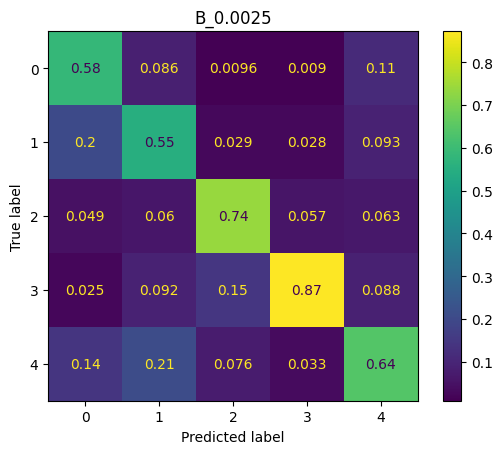

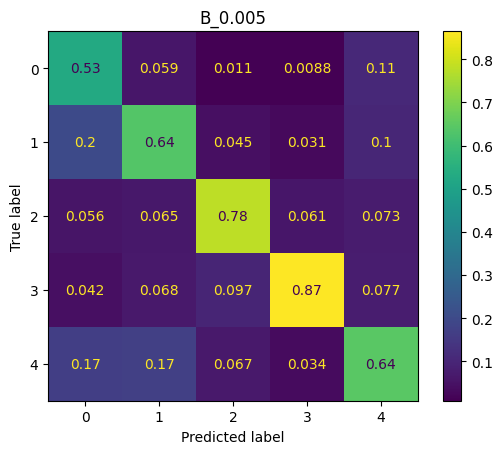

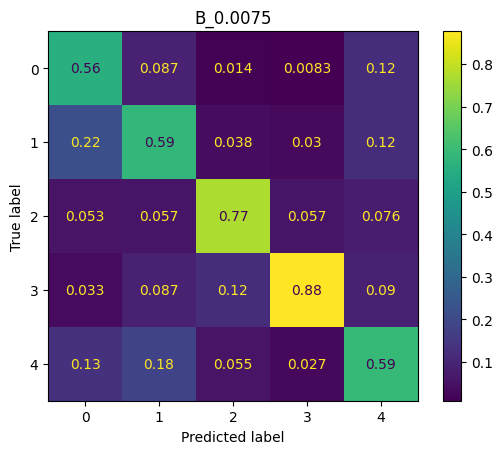

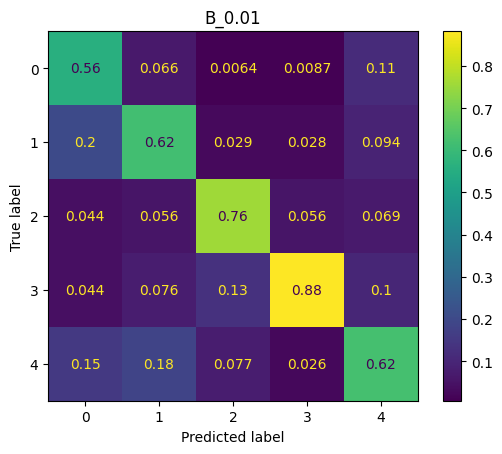

In [12]:
# update based on results of Task A
params.batch_size = 192
ds_train, ds_valid, ds_test, class_weights = data_preprocessing(cwd, params)

print("\n==== Task B: Explore Epsilon ====")
for e in [0.0025, 0.0050, 0.0075, 0.01]:
    print(f"Epsilon: {e}")
    p = dataclasses.replace(params)
    p.epsilon = e
    model = create_model(tf.keras.applications.EfficientNetB0, p)
    run_task(f"B_{e}", model, ds_train, ds_valid, ds_test, p, collector)

#### Task A: Explore Batch-Size

Unable to restore history - starting fresh
= Loading Data =
Found 12837 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Class Weights: {0: 3.9368905243790246, 3: 0.3252317981456148, 1: 1.954956601187757, 2: 1.7935456831517183, 4: 1.6606131160263873}

==== Task A: Explore Batch Size ====
Batch Size: 64
Found 12837 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Running Task: A_64 with params Params(image_size=255, batch_size=64, epochs=75, epsilon=0.005, early_stopping=True, early_stopping_patience=7, adjust_learning_rate=False, opt=<class 'keras.src.optimizers.adam.Adam'>)
Using: <class 'keras.src.optimizers.adam.Adam'>
Using EarlyStopping
Epoch 1/75
  2/201 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - accuracy: 0.2422 - loss: 1.6264   

I0000 00:00:1712392983.472789    4329 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


201/201 ━━━━━━━━━━━━━━━━━━━━ 121s 398ms/step - accuracy: 0.6162 - loss: 1.0590 - val_accuracy: 0.7421 - val_loss: 0.6945
Epoch 2/75
201/201 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.7143 - loss: 0.7617 - val_accuracy: 0.7591 - val_loss: 0.6510
Epoch 3/75
201/201 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.7330 - loss: 0.7099 - val_accuracy: 0.7687 - val_loss: 0.6315
Epoch 4/75
201/201 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.7511 - loss: 0.6777 - val_accuracy: 0.7750 - val_loss: 0.6130
Epoch 5/75
201/201 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.7570 - loss: 0.6574 - val_accuracy: 0.7792 - val_loss: 0.6062
Epoch 6/75
201/201 ━━━━━━━━━━━━━━━━━━━━ 14s 71ms/step - accuracy: 0.7661 - loss: 0.6411 - val_accuracy: 0.7813 - val_loss: 0.6033
Epoch 7/75
201/201 ━━━━━━━━━━━━━━━━━━━━ 14s 71ms/step - accuracy: 0.7679 - loss: 0.6271 - val_accuracy: 0.7773 - val_loss: 0.6049
Epoch 8/75
201/201 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.7791 - loss: 0.6105 - val_accur

W0000 00:00:1712393949.673587    4331 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 854ms/step - accuracy: 0.5851 - loss: 1.2081

W0000 00:00:1712394014.907767    4330 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


67/67 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 0.5856 - loss: 1.2062 - val_accuracy: 0.6900 - val_loss: 0.8209
Epoch 2/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 13s 194ms/step - accuracy: 0.6704 - loss: 0.8815 - val_accuracy: 0.7339 - val_loss: 0.7179
Epoch 3/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 13s 193ms/step - accuracy: 0.6956 - loss: 0.8093 - val_accuracy: 0.7495 - val_loss: 0.6788
Epoch 4/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 13s 194ms/step - accuracy: 0.7172 - loss: 0.7672 - val_accuracy: 0.7610 - val_loss: 0.6533
Epoch 5/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 13s 194ms/step - accuracy: 0.7263 - loss: 0.7408 - val_accuracy: 0.7626 - val_loss: 0.6419
Epoch 6/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 13s 193ms/step - accuracy: 0.7338 - loss: 0.7111 - val_accuracy: 0.7671 - val_loss: 0.6282
Epoch 7/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 13s 193ms/step - accuracy: 0.7468 - loss: 0.6942 - val_accuracy: 0.7717 - val_loss: 0.6179
Epoch 8/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 13s 193ms/step - accuracy: 0.7533 - loss: 0.6857 - val_accuracy: 0.7717 

W0000 00:00:1712394407.834568    4330 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


23/23 ━━━━━━━━━━━━━━━━━━━━ 17s 480ms/step
Saving confusion matrix to artefacts
Batch Size: 256
Found 12837 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Running Task: A_256 with params Params(image_size=255, batch_size=256, epochs=75, epsilon=0.005, early_stopping=True, early_stopping_patience=7, adjust_learning_rate=False, opt=<class 'keras.src.optimizers.adam.Adam'>)
Using: <class 'keras.src.optimizers.adam.Adam'>
Using EarlyStopping
Epoch 1/75
51/51 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.5651 - loss: 1.2422 - val_accuracy: 0.6717 - val_loss: 0.8702
Epoch 2/75
51/51 ━━━━━━━━━━━━━━━━━━━━ 13s 250ms/step - accuracy: 0.6549 - loss: 0.9331 - val_accuracy: 0.7098 - val_loss: 0.7607
Epoch 3/75
51/51 ━━━━━━━━━━━━━━━━━━━━ 13s 249ms/step - accuracy: 0.6853 - loss: 0.8438 - val_accuracy: 0.7294 - val_loss: 0.7137
Epoch 4/75
51/51 ━━━━━━━━━━━━━━━━━━━━ 13s 249ms/step - accuracy: 0.7062 - loss: 0.7953 - val_accuracy: 0.7493

AssertionError: break

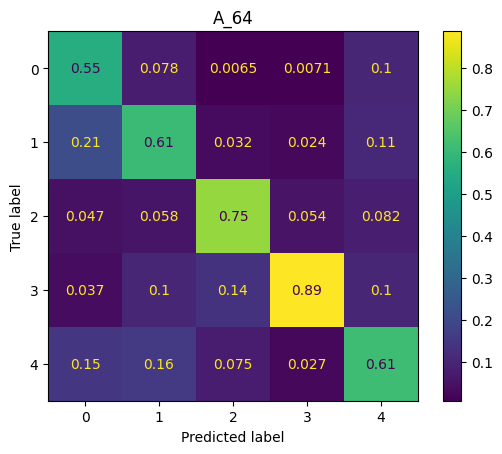

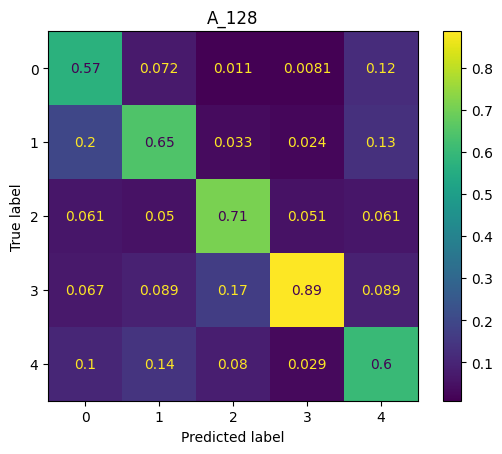

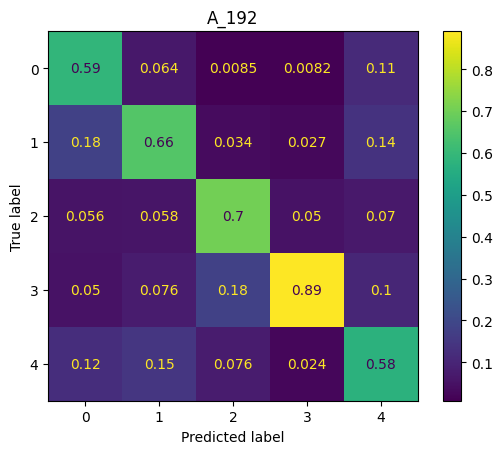

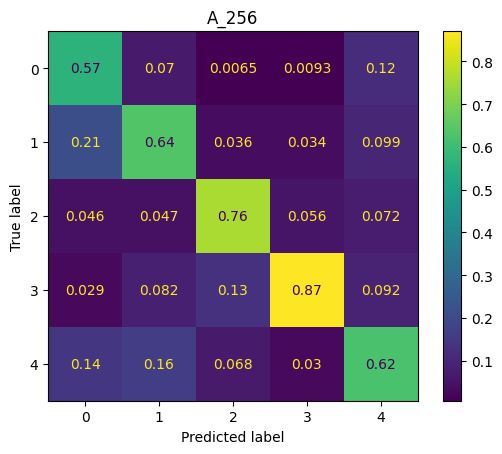

In [8]:
print("\n==== Task A: Explore Batch Size ====")
for bs in [64, 128, 192, 256]:
    print(f"Batch Size: {bs}")
    params.batch_size = bs
    ds_train, ds_valid, ds_test, class_weights = data_preprocessing(cwd, params)
    model = create_model(tf.keras.applications.EfficientNetB0, params)
    run_task(f"A_{bs}", model, cache_dataset(ds_train), cache_dataset(ds_valid), ds_test, params, collector)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

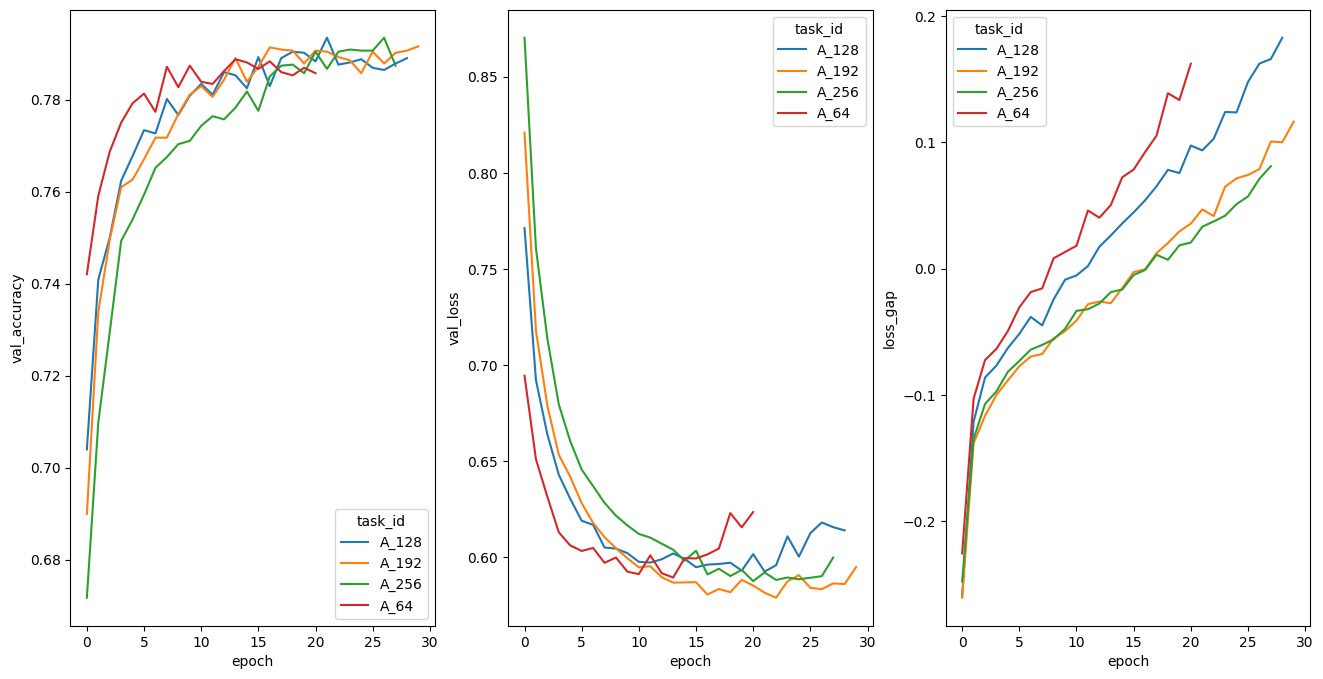

In [10]:
plot_task_comp(collector.get_train_details(), collector.get_train_details().task_id.unique())

In [ ]:
plot_task_comp_by_prefix(collector, "A")

In [9]:
collector.get_test_scores()

,task_id,test_loss,test_accuracy,time_secs
0,A_64,0.573284,0.801636,407
0,A_128,0.577870,0.801869,473
0,A_192,0.576223,0.799299,504
0,A_256,0.581804,0.800234,500


#### Task B: Explore Epsilon

In [ ]:
# update based on results of Task A
params.batch_size = 192
ds_train, ds_valid, ds_test, class_weights = data_preprocessing(Path(cwd), params)

print("\n==== Task B: Explore Epsilon ====")
for e in [0.0025, 0.0050, 0.0075, 0.01]:
    print(f"Epsilon: {e}")
    p = dataclasses.replace(params)
    p.epsilon = e
    model = create_model(tf.keras.applications.EfficientNetB0, p)
    run_task(f"B_{e}", model, ds_train, ds_valid, ds_test, p, collector)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

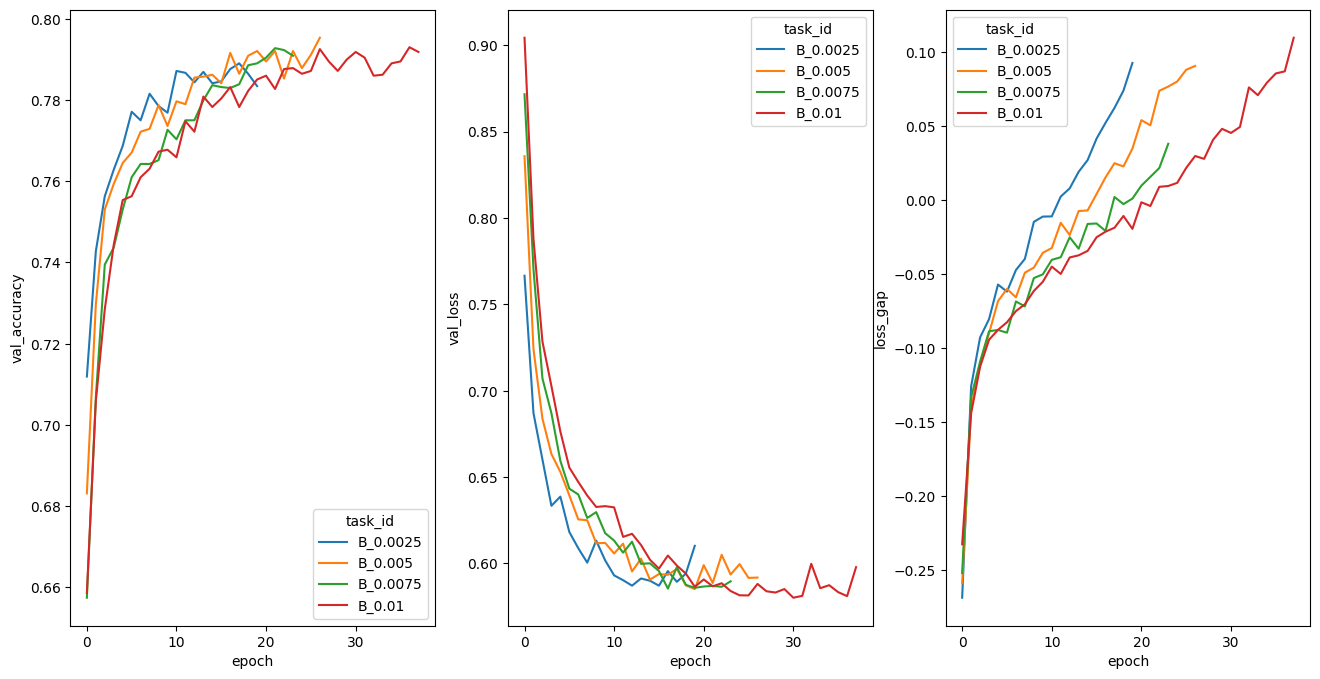

In [35]:
plot_task_comp(collector.get_train_details(), ["B_0.0025", "B_0.005", "B_0.0075", "B_0.01"])

In [ ]:
plot_task_comp_by_prefix(collector, "B")

In [18]:
collector.get_test_scores()

,task_id,test_loss,test_accuracy,time_secs
0,A_64,0.573284,0.801636,407
0,A_128,0.577870,0.801869,473
0,A_192,0.576223,0.799299,504
0,A_256,0.581804,0.800234,500
0,B_0.0025,0.593212,0.792991,637
0,B_0.005,0.595819,0.799299,844
0,B_0.0075,0.596051,0.795093,754
0,B_0.01,0.587769,0.803271,1155


#### Task C: Baseline Model Comparison


==== Task C: Baseline Model Comparison ====
Model: <function ConvNeXtTiny at 0x7d6570b8ab00>
Running Task: C_convnext_tiny with params Params(image_size=255, batch_size=192, epochs=75, epsilon=0.0075, early_stopping=True, early_stopping_patience=7, adjust_learning_rate=False, opt=<class 'keras.src.optimizers.adam.Adam'>)
Using: <class 'keras.src.optimizers.adam.Adam'>
Using EarlyStopping
Epoch 1/75


W0000 00:00:1712400064.355714    4332 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712400064.356158    4332 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712400064.356635    4332 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712400064.357023    4332 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712400064.357406    4332 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712400064.357780    4332 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712400064.358144    4332 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712400064.358503    4332 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.5252 - loss: 1.3168

W0000 00:00:1712400101.298586    4332 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712400101.298936    4332 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712400101.299569    4332 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 559ms/step - accuracy: 0.5262 - loss: 1.3145

W0000 00:00:1712400107.933173    4330 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712400107.933604    4330 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712400107.934049    4330 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712400107.934450    4330 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712400107.934860    4330 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712400107.935255    4330 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712400107.935663    4330 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712400107.936047    4330 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


67/67 ━━━━━━━━━━━━━━━━━━━━ 75s 844ms/step - accuracy: 0.5272 - loss: 1.3121 - val_accuracy: 0.6619 - val_loss: 0.8878
Epoch 2/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 42s 623ms/step - accuracy: 0.6520 - loss: 0.9450 - val_accuracy: 0.6995 - val_loss: 0.7959
Epoch 3/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 42s 623ms/step - accuracy: 0.6792 - loss: 0.8573 - val_accuracy: 0.7140 - val_loss: 0.7579
Epoch 4/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 42s 623ms/step - accuracy: 0.6958 - loss: 0.8125 - val_accuracy: 0.7206 - val_loss: 0.7383
Epoch 5/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 42s 623ms/step - accuracy: 0.7083 - loss: 0.7798 - val_accuracy: 0.7325 - val_loss: 0.7227
Epoch 6/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 42s 623ms/step - accuracy: 0.7143 - loss: 0.7621 - val_accuracy: 0.7379 - val_loss: 0.7085
Epoch 7/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 42s 623ms/step - accuracy: 0.7252 - loss: 0.7410 - val_accuracy: 0.7474 - val_loss: 0.6985
Epoch 8/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 42s 623ms/step - accuracy: 0.7292 - loss: 0.7260 - val_accuracy: 0.750

W0000 00:00:1712401549.668109    4331 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712401549.668602    4331 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712401549.669066    4331 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712401549.669457    4331 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712401549.669859    4331 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712401549.670235    4331 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712401549.670647    4331 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712401549.671054    4331 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


23/23 ━━━━━━━━━━━━━━━━━━━━ 18s 614ms/step


W0000 00:00:1712401563.171455    4329 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712401563.171953    4329 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712401563.172382    4329 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712401563.175459    4329 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712401563.175882    4329 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712401563.176297    4329 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Saving confusion matrix to artefacts
Model: <function ConvNeXtBase at 0x7d6570b8ac20>
350926856/350926856 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Running Task: C_convnext_base with params Params(image_size=255, batch_size=192, epochs=75, epsilon=0.0075, early_stopping=True, early_stopping_patience=7, adjust_learning_rate=False, opt=<class 'keras.src.optimizers.adam.Adam'>)
Using: <class 'keras.src.optimizers.adam.Adam'>
Using EarlyStopping
Epoch 1/75


W0000 00:00:1712401619.610593    4329 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5462 - loss: 1.2774

W0000 00:00:1712401730.667348    4329 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712401764.419762    4330 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712401764.420216    4330 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712401764.420769    4330 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


67/67 ━━━━━━━━━━━━━━━━━━━━ 191s 2s/step - accuracy: 0.5471 - loss: 1.2750 - val_accuracy: 0.6822 - val_loss: 0.8191
Epoch 2/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.6713 - loss: 0.8839 - val_accuracy: 0.7388 - val_loss: 0.7112
Epoch 3/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.7056 - loss: 0.7780 - val_accuracy: 0.7636 - val_loss: 0.6529
Epoch 4/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.7276 - loss: 0.7245 - val_accuracy: 0.7818 - val_loss: 0.6143
Epoch 5/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.7488 - loss: 0.6783 - val_accuracy: 0.7862 - val_loss: 0.5937
Epoch 6/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.7643 - loss: 0.6416 - val_accuracy: 0.7970 - val_loss: 0.5677
Epoch 7/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.7753 - loss: 0.6144 - val_accuracy: 0.8012 - val_loss: 0.5522
Epoch 8/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.7839 - loss: 0.6037 - val_accuracy: 0.8051 - val_loss: 0.

W0000 00:00:1712405143.670944    4330 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


23/23 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step


W0000 00:00:1712405175.520735    4330 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712405175.521096    4330 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712405175.521633    4330 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Saving confusion matrix to artefacts
Model: <function EfficientNetB0 at 0x7d6570b8b880>
Running Task: C_efficientnetb0 with params Params(image_size=255, batch_size=192, epochs=75, epsilon=0.0075, early_stopping=True, early_stopping_patience=7, adjust_learning_rate=False, opt=<class 'keras.src.optimizers.adam.Adam'>)
Using: <class 'keras.src.optimizers.adam.Adam'>
Using EarlyStopping
Epoch 1/75
 1/67 ━━━━━━━━━━━━━━━━━━━━ 39:31 36s/step - accuracy: 0.1979 - loss: 1.6977

W0000 00:00:1712405219.185704    4329 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 587ms/step - accuracy: 0.5362 - loss: 1.2614

W0000 00:00:1712405266.126265    4332 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


67/67 ━━━━━━━━━━━━━━━━━━━━ 90s 821ms/step - accuracy: 0.5371 - loss: 1.2593 - val_accuracy: 0.6806 - val_loss: 0.8462
Epoch 2/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 13s 192ms/step - accuracy: 0.6609 - loss: 0.9166 - val_accuracy: 0.7250 - val_loss: 0.7398
Epoch 3/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 13s 192ms/step - accuracy: 0.6900 - loss: 0.8231 - val_accuracy: 0.7484 - val_loss: 0.6965
Epoch 4/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 13s 192ms/step - accuracy: 0.7057 - loss: 0.7820 - val_accuracy: 0.7570 - val_loss: 0.6706
Epoch 5/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 13s 192ms/step - accuracy: 0.7211 - loss: 0.7531 - val_accuracy: 0.7621 - val_loss: 0.6596
Epoch 6/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 13s 192ms/step - accuracy: 0.7281 - loss: 0.7282 - val_accuracy: 0.7631 - val_loss: 0.6428
Epoch 7/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 13s 192ms/step - accuracy: 0.7385 - loss: 0.7057 - val_accuracy: 0.7682 - val_loss: 0.6339
Epoch 8/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 13s 191ms/step - accuracy: 0.7454 - loss: 0.6893 - val_accuracy: 0.772

W0000 00:00:1712405669.027084    4330 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


23/23 ━━━━━━━━━━━━━━━━━━━━ 16s 486ms/step
Saving confusion matrix to artefacts
Model: <function EfficientNetV2B0 at 0x7d6570ba8430>
24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Running Task: C_efficientnetv2-b0 with params Params(image_size=255, batch_size=192, epochs=75, epsilon=0.0075, early_stopping=True, early_stopping_patience=7, adjust_learning_rate=False, opt=<class 'keras.src.optimizers.adam.Adam'>)
Using: <class 'keras.src.optimizers.adam.Adam'>
Using EarlyStopping
Epoch 1/75
 2/67 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 0.2096 - loss: 1.6576   

W0000 00:00:1712405753.466506    4330 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 912ms/step - accuracy: 0.5341 - loss: 1.2890

W0000 00:00:1712405822.570918    4329 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


67/67 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.5350 - loss: 1.2870 - val_accuracy: 0.6603 - val_loss: 0.8901
Epoch 2/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - accuracy: 0.6502 - loss: 0.9444 - val_accuracy: 0.7168 - val_loss: 0.7603
Epoch 3/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - accuracy: 0.6847 - loss: 0.8453 - val_accuracy: 0.7397 - val_loss: 0.7155
Epoch 4/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - accuracy: 0.7113 - loss: 0.7918 - val_accuracy: 0.7456 - val_loss: 0.6916
Epoch 5/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - accuracy: 0.7194 - loss: 0.7659 - val_accuracy: 0.7500 - val_loss: 0.6711
Epoch 6/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - accuracy: 0.7282 - loss: 0.7360 - val_accuracy: 0.7572 - val_loss: 0.6579
Epoch 7/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - accuracy: 0.7373 - loss: 0.7154 - val_accuracy: 0.7617 - val_loss: 0.6458
Epoch 8/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - accuracy: 0.7418 - loss: 0.6944 - val_accuracy: 0.7673 

W0000 00:00:1712406198.109996    4331 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


23/23 ━━━━━━━━━━━━━━━━━━━━ 17s 503ms/step
Saving confusion matrix to artefacts


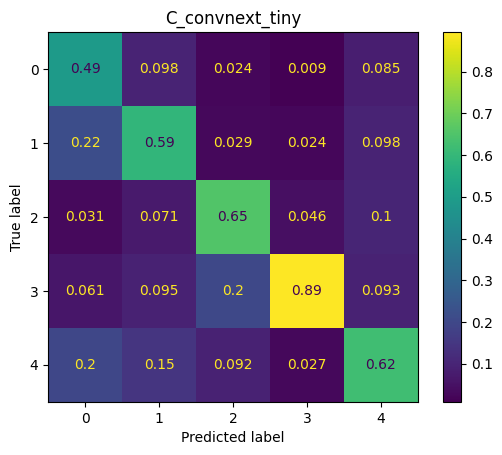

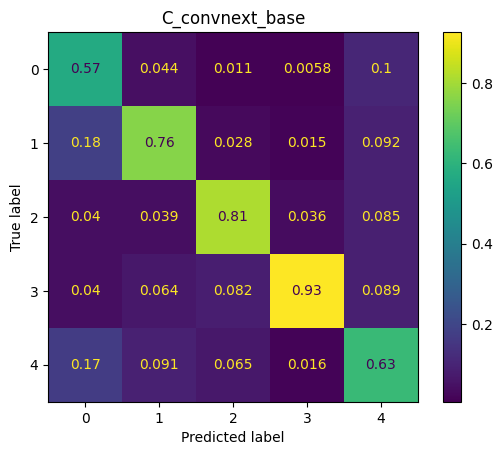

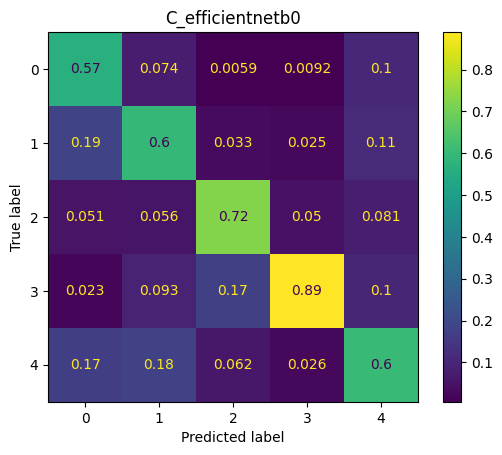

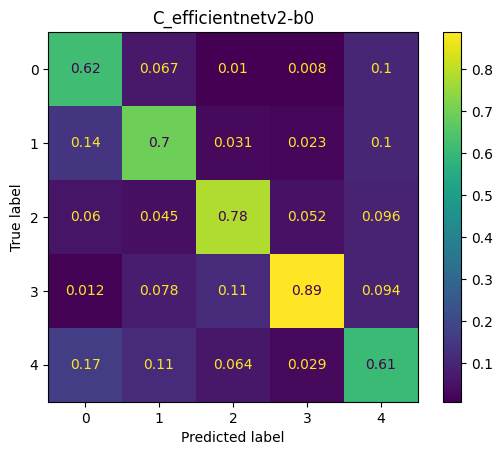

In [38]:
# update based on results of Task B
params.epsilon = 0.0075

print("\n==== Task C: Baseline Model Comparison ====")
for m in [tf.keras.applications.ConvNeXtTiny, tf.keras.applications.ConvNeXtBase,
          tf.keras.applications.EfficientNetB0, tf.keras.applications.EfficientNetV2B0]:
    print(f"Model: {m}")
    model = create_model(m, params)
    run_task(f"C_{model.base_model.name}", model, cache_dataset(ds_train), cache_dataset(ds_valid), ds_test, params, collector)

In [39]:
collector.get_test_scores()

,task_id,test_loss,test_accuracy,time_secs
0,A_64,0.573284,0.801636,407
0,A_128,0.577870,0.801869,473
0,A_192,0.576223,0.799299,504
0,A_256,0.581804,0.800234,500
0,B_0.0025,0.593212,0.792991,637
0,B_0.005,0.595819,0.799299,844
0,B_0.0075,0.596051,0.795093,754
0,B_0.01,0.587769,0.803271,1155
0,C_convnext_tiny,0.590688,0.792523,1489
0,C_convnext_base,0.458859,0.844393,3534


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

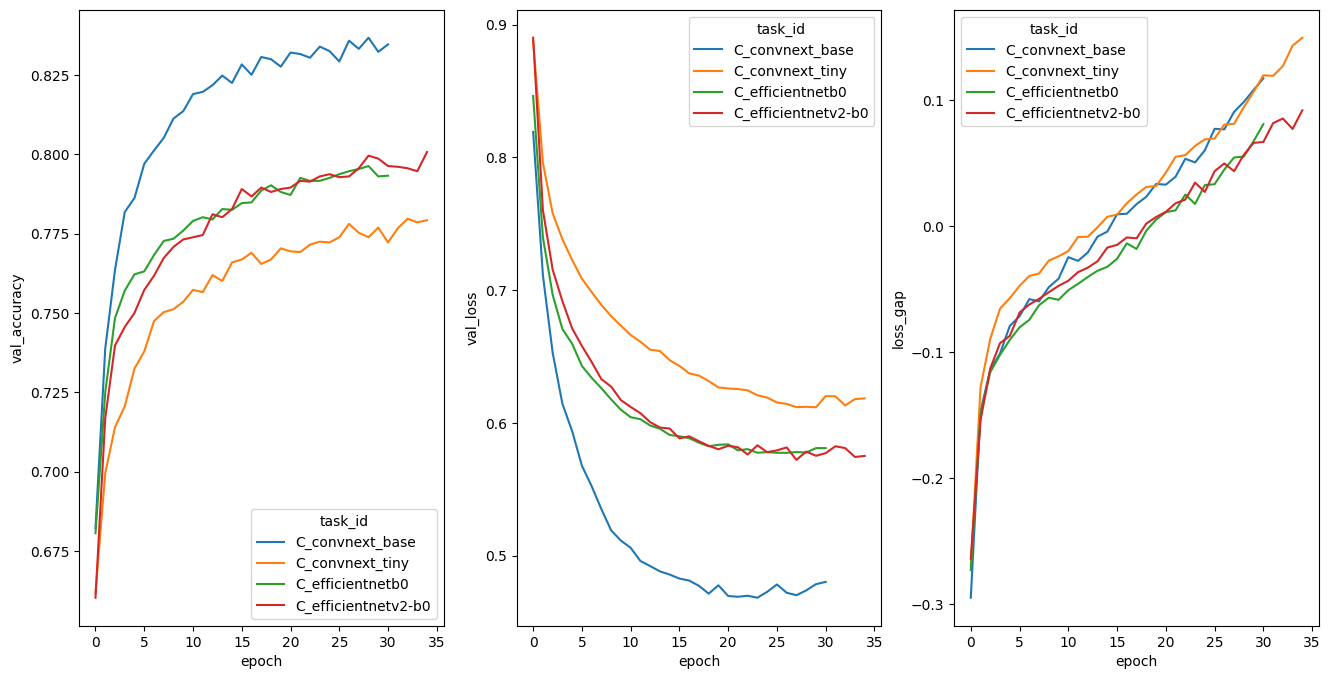

In [42]:
plot_task_comp_by_prefix(collector, "C")

In [7]:
collector.get_test_scores()

,task_id,test_loss,test_accuracy,time_secs
0,A_64,0.573284,0.801636,407
1,A_128,0.577870,0.801869,473
2,A_192,0.576223,0.799299,504
3,A_256,0.581804,0.800234,500
4,B_0.0025,0.593212,0.792991,637
5,B_0.005,0.595819,0.799299,844
6,B_0.0075,0.596051,0.795093,754
7,B_0.01,0.587769,0.803271,1155
8,C_convnext_tiny,0.590688,0.792523,1489
9,C_convnext_base,0.458859,0.844393,3534


#### Task D: Best-of-Breed Model

In [9]:
# update based on results of Tasks A&B
params.batch_size = 192
params.epsilon = 0.0075
params.opt = AdamW
print(params)

Params(image_size=255, batch_size=192, epochs=75, epsilon=0.0075, early_stopping=True, early_stopping_patience=7, adjust_learning_rate=False, opt=<class 'keras.src.optimizers.adamw.AdamW'>)



==== Task D: Best-of-Breed Model ====
24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Running Task: D_init with params Params(image_size=255, batch_size=192, epochs=75, epsilon=0.0075, early_stopping=True, early_stopping_patience=7, adjust_learning_rate=False, opt=<class 'keras.src.optimizers.adamw.AdamW'>)
Using: <class 'keras.src.optimizers.adamw.AdamW'>
Using EarlyStopping
Epoch 1/75
      1/Unknown 95s 95s/step - accuracy: 0.1667 - loss: 2.4116

I0000 00:00:1712410072.769318     121 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


    141/Unknown 201s 757ms/step - accuracy: 0.5315 - loss: 1.4076

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


142/142 ━━━━━━━━━━━━━━━━━━━━ 223s 906ms/step - accuracy: 0.5325 - loss: 1.4041 - val_accuracy: 0.7364 - val_loss: 0.8406
Epoch 2/75
142/142 ━━━━━━━━━━━━━━━━━━━━ 134s 688ms/step - accuracy: 0.6762 - loss: 0.8941 - val_accuracy: 0.7561 - val_loss: 0.7266
Epoch 3/75
142/142 ━━━━━━━━━━━━━━━━━━━━ 132s 683ms/step - accuracy: 0.7162 - loss: 0.7883 - val_accuracy: 0.7600 - val_loss: 0.6930
Epoch 4/75
142/142 ━━━━━━━━━━━━━━━━━━━━ 134s 687ms/step - accuracy: 0.7319 - loss: 0.7390 - val_accuracy: 0.7708 - val_loss: 0.6461
Epoch 5/75
142/142 ━━━━━━━━━━━━━━━━━━━━ 132s 675ms/step - accuracy: 0.7414 - loss: 0.7038 - val_accuracy: 0.7757 - val_loss: 0.6292
Epoch 6/75
142/142 ━━━━━━━━━━━━━━━━━━━━ 132s 683ms/step - accuracy: 0.7525 - loss: 0.6720 - val_accuracy: 0.7778 - val_loss: 0.6150
Epoch 7/75
142/142 ━━━━━━━━━━━━━━━━━━━━ 133s 687ms/step - accuracy: 0.7641 - loss: 0.6418 - val_accuracy: 0.7785 - val_loss: 0.6216
Epoch 8/75
142/142 ━━━━━━━━━━━━━━━━━━━━ 130s 668ms/step - accuracy: 0.7675 - loss: 0.62

2024-04-06 14:19:08.248668: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[128,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[192,32,64,64]{3,2,1,0}, f32[192,128,64,64]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-04-06 14:19:08.367926: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.119448838s
Trying algorithm eng0{} for conv (f32[128,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[192,32,64,64]{3,2,1,0}, f32[192,128,64,64]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-04-06 14:19:09.771291: E external/

    142/Unknown 326s 1s/step - accuracy: 0.7468 - loss: 0.7273

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


142/142 ━━━━━━━━━━━━━━━━━━━━ 337s 1s/step - accuracy: 0.7471 - loss: 0.7264 - val_accuracy: 0.8315 - val_loss: 0.4963
Epoch 2/75
142/142 ━━━━━━━━━━━━━━━━━━━━ 139s 722ms/step - accuracy: 0.8690 - loss: 0.3855 - val_accuracy: 0.8100 - val_loss: 0.5417
Epoch 3/75
142/142 ━━━━━━━━━━━━━━━━━━━━ 138s 714ms/step - accuracy: 0.9009 - loss: 0.2903 - val_accuracy: 0.8241 - val_loss: 0.5311
Epoch 4/75
142/142 ━━━━━━━━━━━━━━━━━━━━ 139s 718ms/step - accuracy: 0.9235 - loss: 0.2319 - val_accuracy: 0.8044 - val_loss: 0.6817
Epoch 5/75
142/142 ━━━━━━━━━━━━━━━━━━━━ 139s 720ms/step - accuracy: 0.9442 - loss: 0.1705 - val_accuracy: 0.8042 - val_loss: 0.6559
Epoch 6/75
142/142 ━━━━━━━━━━━━━━━━━━━━ 139s 722ms/step - accuracy: 0.9375 - loss: 0.1901 - val_accuracy: 0.7804 - val_loss: 0.7292
Epoch 7/75
142/142 ━━━━━━━━━━━━━━━━━━━━ 138s 716ms/step - accuracy: 0.8957 - loss: 0.3239 - val_accuracy: 0.8252 - val_loss: 0.5506
Epoch 8/75
142/142 ━━━━━━━━━━━━━━━━━━━━ 137s 717ms/step - accuracy: 0.9435 - loss: 0.1777 

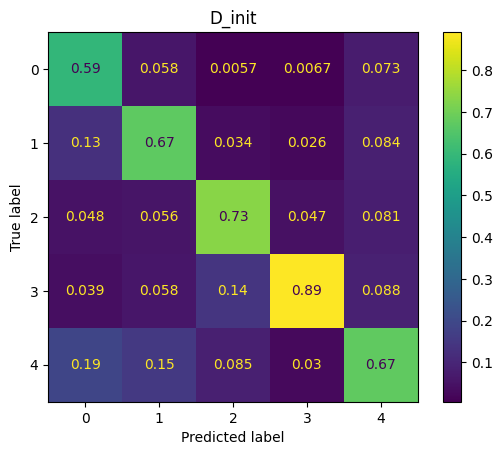

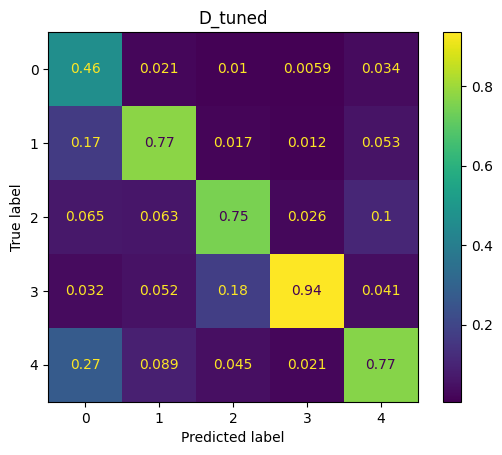

In [10]:
# update based on results of Tasks A&B
params.batch_size = 192
params.epsilon = 0.0075
params.opt = AdamW

print("\n==== Task D: Best-of-Breed Model ====")
# def over_sample_class(ds: Dataset, class_label: int, batch_size: int, num_repeats: int = 1) -> Dataset:
# oversample & augment dataset
ds_train_aug = augment_dataset(over_sample_class(ds_train, 0, params.batch_size), 2)
# ds_train_aug = ds_train_aug.unbatch()
# #ds_train_aug = augment_dataset(ds_train_aug, 2)
# ds_train_aug = ds_train_aug.batch(params.batch_size)
ds_valid = cache_dataset(ds_valid)
# initial training
model_d = create_model(tf.keras.applications.EfficientNetV2B0, params, batch_norm=True)
run_task(f"D_init", model_d, ds_train_aug, ds_valid, ds_test, params, collector, class_weights)
# fine-tune by allowing base model to be re-trained
model_d.base_model.trainable = True
ft_params = dataclasses.replace(params)
ft_params.epsilon = 1e-5
ft_params.early_stopping_patience = 3
run_task(f"D_tuned", model_d, ds_train_aug, ds_valid, ds_test, ft_params, collector, class_weights)
#del model_d

In [13]:
del model_d

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

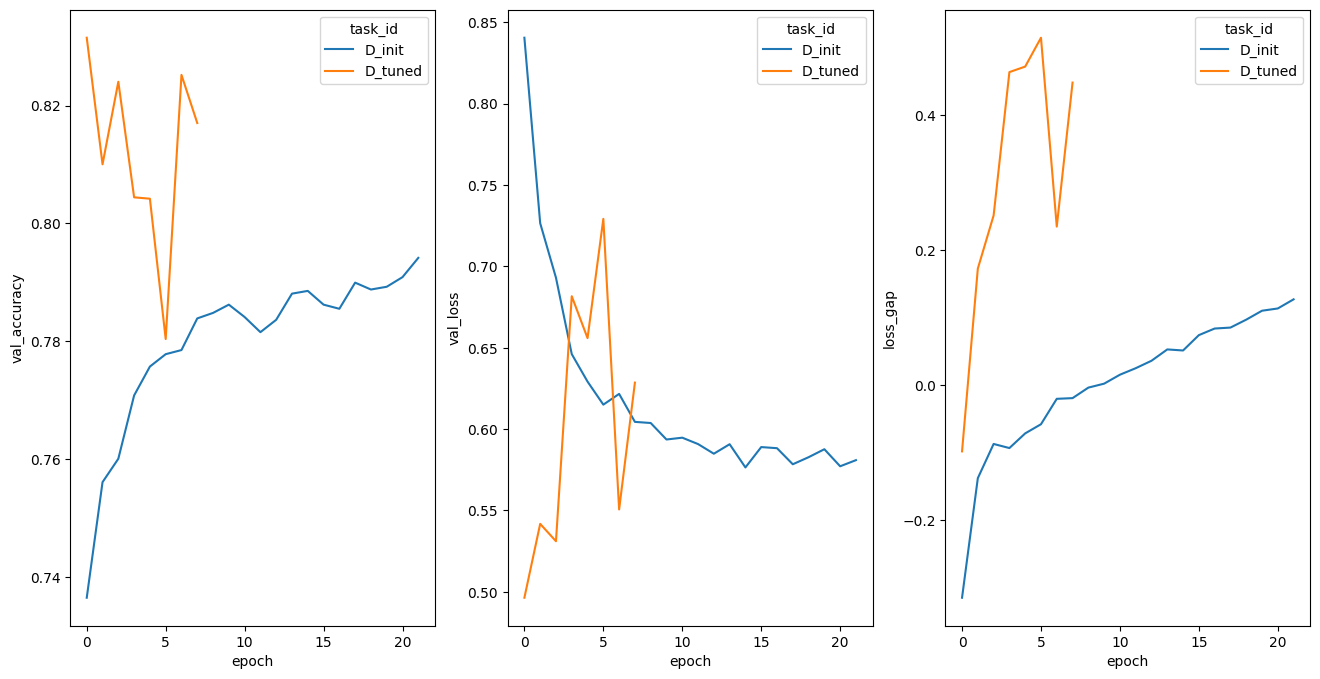

In [12]:
plot_task_comp(collector.get_train_details(), ["D_init", "D_tuned"])

In [11]:
collector.get_test_scores()

,task_id,test_loss,test_accuracy,time_secs
0,A_64,0.573284,0.801636,407
1,A_128,0.577870,0.801869,473
2,A_192,0.576223,0.799299,504
3,A_256,0.581804,0.800234,500
4,B_0.0025,0.593212,0.792991,637
5,B_0.005,0.595819,0.799299,844
6,B_0.0075,0.596051,0.795093,754
7,B_0.01,0.587769,0.803271,1155
8,C_convnext_tiny,0.590688,0.792523,1489
9,C_convnext_base,0.458859,0.844393,3534


In [ ]:
print("\n========================")
print("==== Ablation Study ====")
print("========================")

print("\n==== Task E: Remove Fine-Tuning ====")
model = create_model(tf.keras.applications.ConvNeXtBase, params, bn=True)
run_task(f"E", model, ds_train_aug, ds_valid, ds_test, params, collector, class_weights)
del model

In [7]:
# update based on results of Tasks A&B
params.batch_size = 192
params.epsilon = 0.0075
params.opt = AdamW
ds_valid = cache_dataset(ds_valid)
print(params)

Params(image_size=255, batch_size=192, epochs=75, epsilon=0.0075, early_stopping=True, early_stopping_patience=7, adjust_learning_rate=False, opt=<class 'keras.src.optimizers.adamw.AdamW'>)



==== Task F: Remove Data Augmentation (the over-sampling piece) ====
24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Running Task: F_0 with params Params(image_size=255, batch_size=192, epochs=75, epsilon=0.0075, early_stopping=True, early_stopping_patience=7, adjust_learning_rate=False, opt=<class 'keras.src.optimizers.adamw.AdamW'>)
Using: <class 'keras.src.optimizers.adamw.AdamW'>
Using EarlyStopping
Epoch 1/75
  1/134 ━━━━━━━━━━━━━━━━━━━━ 2:16:38 62s/step - accuracy: 0.3958 - loss: 1.8776

I0000 00:00:1712435462.890217     114 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


134/134 ━━━━━━━━━━━━━━━━━━━━ 195s 1s/step - accuracy: 0.5724 - loss: 1.3339 - val_accuracy: 0.7343 - val_loss: 0.8535
Epoch 2/75
134/134 ━━━━━━━━━━━━━━━━━━━━ 79s 569ms/step - accuracy: 0.6858 - loss: 0.8727 - val_accuracy: 0.7563 - val_loss: 0.7449
Epoch 3/75
134/134 ━━━━━━━━━━━━━━━━━━━━ 78s 566ms/step - accuracy: 0.7169 - loss: 0.7812 - val_accuracy: 0.7647 - val_loss: 0.6810
Epoch 4/75
134/134 ━━━━━━━━━━━━━━━━━━━━ 77s 554ms/step - accuracy: 0.7315 - loss: 0.7292 - val_accuracy: 0.7678 - val_loss: 0.6443
Epoch 5/75
134/134 ━━━━━━━━━━━━━━━━━━━━ 77s 554ms/step - accuracy: 0.7495 - loss: 0.6812 - val_accuracy: 0.7738 - val_loss: 0.6219
Epoch 6/75
134/134 ━━━━━━━━━━━━━━━━━━━━ 78s 563ms/step - accuracy: 0.7599 - loss: 0.6540 - val_accuracy: 0.7848 - val_loss: 0.6066
Epoch 7/75
134/134 ━━━━━━━━━━━━━━━━━━━━ 75s 544ms/step - accuracy: 0.7687 - loss: 0.6314 - val_accuracy: 0.7794 - val_loss: 0.6006
Epoch 8/75
134/134 ━━━━━━━━━━━━━━━━━━━━ 77s 556ms/step - accuracy: 0.7723 - loss: 0.6240 - val_a

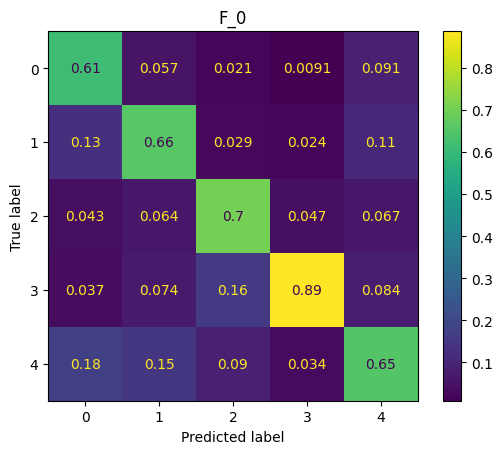

In [8]:
print("\n==== Task F: Remove Data Augmentation (the over-sampling piece) ====")
ds_train_aug = augment_dataset(ds_train, 2)
model = create_model(tf.keras.applications.EfficientNetV2B0, params, batch_norm=True)
run_task(f"F_0", model, ds_train_aug, ds_valid, ds_test, params, collector, class_weights)


In [9]:
collector.get_test_scores()

,task_id,test_loss,test_accuracy,time_secs
0,A_64,0.573284,0.801636,407
1,A_128,0.577870,0.801869,473
2,A_192,0.576223,0.799299,504
3,A_256,0.581804,0.800234,500
4,B_0.0025,0.593212,0.792991,637
5,B_0.005,0.595819,0.799299,844
6,B_0.0075,0.596051,0.795093,754
7,B_0.01,0.587769,0.803271,1155
8,C_convnext_tiny,0.590688,0.792523,1489
9,C_convnext_base,0.458859,0.844393,3534



==== Task F: Remove Data Augmentation ====
Running Task: F with params Params(image_size=255, batch_size=192, epochs=75, epsilon=0.0075, early_stopping=True, early_stopping_patience=7, adjust_learning_rate=False, opt=<class 'keras.src.optimizers.adamw.AdamW'>)
Using: <class 'keras.src.optimizers.adamw.AdamW'>
Using EarlyStopping
Epoch 1/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.4864 - loss: 1.6273 - val_accuracy: 0.6748 - val_loss: 0.9234
Epoch 2/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 23s 306ms/step - accuracy: 0.6536 - loss: 0.9848 - val_accuracy: 0.7393 - val_loss: 0.8213
Epoch 3/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 23s 309ms/step - accuracy: 0.6915 - loss: 0.8600 - val_accuracy: 0.7481 - val_loss: 0.7569
Epoch 4/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 22s 300ms/step - accuracy: 0.7046 - loss: 0.8109 - val_accuracy: 0.7575 - val_loss: 0.7057
Epoch 5/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 23s 303ms/step - accuracy: 0.7190 - loss: 0.7667 - val_accuracy: 0.7617 - val_loss: 0.6784
Epoch 6/75
67/67 ━━━━━━━━

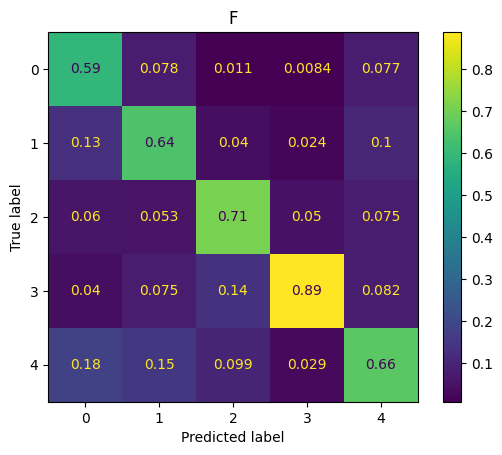

In [15]:
print("\n==== Task F: Remove Data Augmentation ====")
model = create_model(tf.keras.applications.EfficientNetV2B0, params, batch_norm=True)
run_task(f"F", model, ds_train, ds_valid, ds_test, params, collector, class_weights)
del model


==== Task G: Remove Class Weights ====
Running Task: G with params Params(image_size=255, batch_size=192, epochs=75, epsilon=0.0075, early_stopping=True, early_stopping_patience=7, adjust_learning_rate=False, opt=<class 'keras.src.optimizers.adamw.AdamW'>)
Using: <class 'keras.src.optimizers.adamw.AdamW'>
Using EarlyStopping
Epoch 1/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 105s 900ms/step - accuracy: 0.5100 - loss: 1.5147 - val_accuracy: 0.7000 - val_loss: 0.9294
Epoch 2/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 23s 305ms/step - accuracy: 0.6606 - loss: 0.9948 - val_accuracy: 0.7364 - val_loss: 0.8228
Epoch 3/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 23s 312ms/step - accuracy: 0.6875 - loss: 0.8741 - val_accuracy: 0.7509 - val_loss: 0.7756
Epoch 4/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 23s 304ms/step - accuracy: 0.7112 - loss: 0.7905 - val_accuracy: 0.7591 - val_loss: 0.7204
Epoch 5/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 22s 300ms/step - accuracy: 0.7299 - loss: 0.7529 - val_accuracy: 0.7631 - val_loss: 0.6967
Epoch 6/75
67/67 ━━━━━━━━━

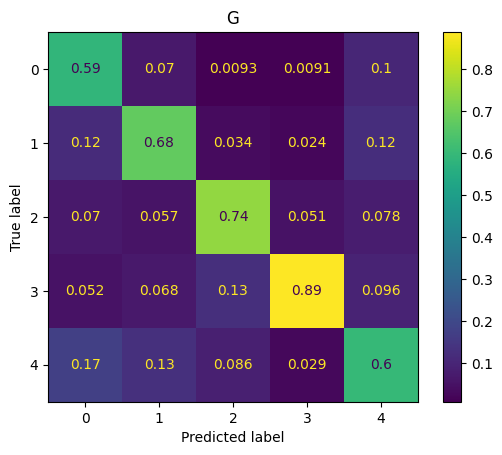

In [17]:
print("\n==== Task G: Remove Class Weights ====")
model = create_model(tf.keras.applications.EfficientNetV2B0, params, batch_norm=True)
run_task(f"G", model, ds_train, ds_valid, ds_test, params, collector)
del model


==== Task H: Remove Batch Norm ====
Running Task: H with params Params(image_size=255, batch_size=192, epochs=75, epsilon=0.0075, early_stopping=True, early_stopping_patience=7, adjust_learning_rate=False, opt=<class 'keras.src.optimizers.adamw.AdamW'>)
Using: <class 'keras.src.optimizers.adamw.AdamW'>
Using EarlyStopping
Epoch 1/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 104s 919ms/step - accuracy: 0.5183 - loss: 1.3011 - val_accuracy: 0.6577 - val_loss: 0.8904
Epoch 2/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 23s 309ms/step - accuracy: 0.6559 - loss: 0.9388 - val_accuracy: 0.7117 - val_loss: 0.7646
Epoch 3/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 23s 308ms/step - accuracy: 0.6905 - loss: 0.8323 - val_accuracy: 0.7376 - val_loss: 0.7127
Epoch 4/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 23s 305ms/step - accuracy: 0.7153 - loss: 0.7785 - val_accuracy: 0.7442 - val_loss: 0.6903
Epoch 5/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 22s 299ms/step - accuracy: 0.7251 - loss: 0.7480 - val_accuracy: 0.7533 - val_loss: 0.6675
Epoch 6/75
67/67 ━━━━━━━━━━━━

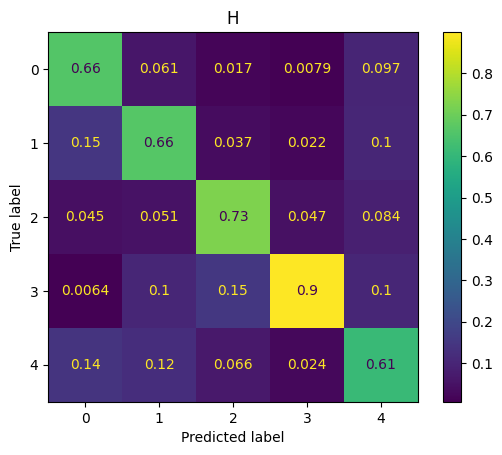

In [18]:
print("\n==== Task H: Remove Batch Norm ====")
model = create_model(tf.keras.applications.EfficientNetV2B0, params)
run_task(f"H", model, ds_train, ds_valid, ds_test, params, collector)
del model


==== Task I: Regress to the Adam Optimiser ====
24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Running Task: I with params Params(image_size=255, batch_size=192, epochs=75, epsilon=0.0075, early_stopping=True, early_stopping_patience=7, adjust_learning_rate=False, opt=<class 'keras.src.optimizers.adam.Adam'>)
Using: <class 'keras.src.optimizers.adam.Adam'>
Using EarlyStopping
Epoch 1/75
 1/67 ━━━━━━━━━━━━━━━━━━━━ 1:16:11 69s/step - accuracy: 0.2917 - loss: 1.5524

I0000 00:00:1712423808.356784     114 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


67/67 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 0.5584 - loss: 1.2450 - val_accuracy: 0.6659 - val_loss: 0.8721
Epoch 2/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 31s 425ms/step - accuracy: 0.6542 - loss: 0.9285 - val_accuracy: 0.7126 - val_loss: 0.7535
Epoch 3/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 31s 427ms/step - accuracy: 0.6882 - loss: 0.8331 - val_accuracy: 0.7393 - val_loss: 0.7124
Epoch 4/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 32s 436ms/step - accuracy: 0.7066 - loss: 0.7878 - val_accuracy: 0.7516 - val_loss: 0.6805
Epoch 5/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 31s 426ms/step - accuracy: 0.7213 - loss: 0.7451 - val_accuracy: 0.7556 - val_loss: 0.6694
Epoch 6/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 31s 431ms/step - accuracy: 0.7265 - loss: 0.7259 - val_accuracy: 0.7575 - val_loss: 0.6523
Epoch 7/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 30s 414ms/step - accuracy: 0.7419 - loss: 0.7041 - val_accuracy: 0.7614 - val_loss: 0.6363
Epoch 8/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 30s 418ms/step - accuracy: 0.7482 - loss: 0.6973 - val_accuracy: 0.7675 

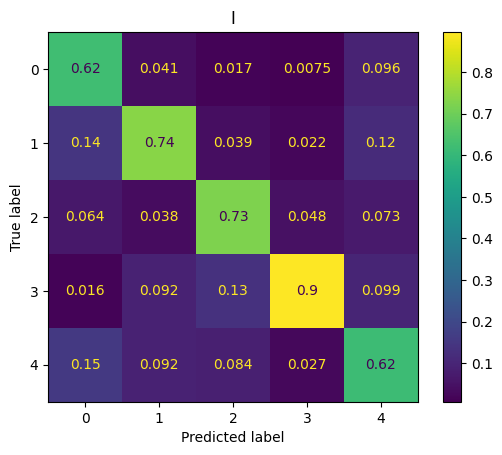

In [6]:
# update based on results of Tasks A&B
params.batch_size = 192
params.epsilon = 0.0075

print("\n==== Task I: Regress to the Adam Optimiser ====")
params.opt = Adam
model = create_model(tf.keras.applications.EfficientNetV2B0, params)
run_task(f"I", model, ds_train, ds_valid, ds_test, params, collector)
del model


==== Task J: Remove a FC Layer ====
Running Task: J_1 with params Params(image_size=255, batch_size=192, epochs=75, epsilon=0.0075, early_stopping=True, early_stopping_patience=7, adjust_learning_rate=False, opt=<class 'keras.src.optimizers.adam.Adam'>)
Using: <class 'keras.src.optimizers.adam.Adam'>
Using EarlyStopping
Epoch 1/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - accuracy: 0.5533 - loss: 1.2042 - val_accuracy: 0.6953 - val_loss: 0.8087
Epoch 2/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 31s 434ms/step - accuracy: 0.6863 - loss: 0.8487 - val_accuracy: 0.7283 - val_loss: 0.7264
Epoch 3/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 31s 430ms/step - accuracy: 0.7186 - loss: 0.7733 - val_accuracy: 0.7439 - val_loss: 0.6904
Epoch 4/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 32s 436ms/step - accuracy: 0.7316 - loss: 0.7355 - val_accuracy: 0.7537 - val_loss: 0.6678
Epoch 5/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 30s 418ms/step - accuracy: 0.7409 - loss: 0.7064 - val_accuracy: 0.7624 - val_loss: 0.6552
Epoch 6/75
67/67 ━━━━━━━━━━━━━━━━━

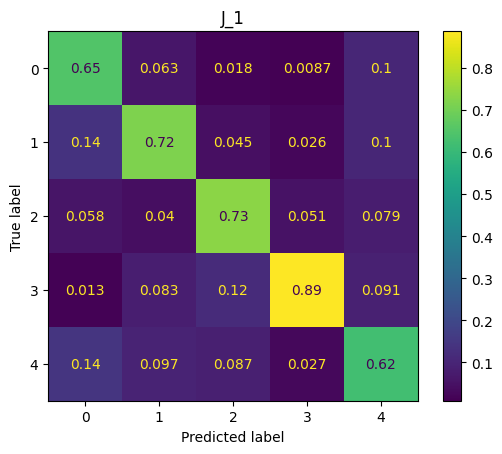

In [7]:
print("\n==== Task J: Remove a FC Layer ====")
model = create_model(tf.keras.applications.EfficientNetV2B0, params, 1)
run_task(f"J_1", model, ds_train, ds_valid, ds_test, params, collector)
del model

In [9]:
params.epochs = 5
print(params)

Params(image_size=255, batch_size=192, epochs=5, epsilon=0.005, early_stopping=True, early_stopping_patience=7, adjust_learning_rate=False, opt=<class 'keras.src.optimizers.adam.Adam'>)



==== Task K: Create a Custom Convnet ====
Running Task: K with params Params(image_size=255, batch_size=192, epochs=5, epsilon=0.005, early_stopping=True, early_stopping_patience=7, adjust_learning_rate=False, opt=<class 'keras.src.optimizers.adam.Adam'>)
Using: <class 'keras.src.optimizers.adam.Adam'>
Using EarlyStopping
Epoch 1/5


W0000 00:00:1712495337.335774     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - accuracy: 0.5812 - loss: 1.5370

W0000 00:00:1712495381.796260     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 673ms/step - accuracy: 0.5816 - loss: 1.5353

W0000 00:00:1712495385.692455     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


67/67 ━━━━━━━━━━━━━━━━━━━━ 70s 829ms/step - accuracy: 0.5819 - loss: 1.5336 - val_accuracy: 0.6164 - val_loss: 1.2166
Epoch 2/5
67/67 ━━━━━━━━━━━━━━━━━━━━ 63s 682ms/step - accuracy: 0.6154 - loss: 1.1977 - val_accuracy: 0.6164 - val_loss: 1.2084
Epoch 3/5
67/67 ━━━━━━━━━━━━━━━━━━━━ 82s 683ms/step - accuracy: 0.6160 - loss: 1.1910 - val_accuracy: 0.6164 - val_loss: 1.1884
Epoch 4/5
67/67 ━━━━━━━━━━━━━━━━━━━━ 48s 689ms/step - accuracy: 0.6186 - loss: 1.1891 - val_accuracy: 0.6164 - val_loss: 1.1905
Epoch 5/5
67/67 ━━━━━━━━━━━━━━━━━━━━ 48s 681ms/step - accuracy: 0.6152 - loss: 1.1925 - val_accuracy: 0.6164 - val_loss: 1.1964
Restoring model weights from the end of the best epoch: 3.
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 339ms/step - accuracy: 0.4172 - loss: 1.5660
 2/23 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step

W0000 00:00:1712495643.720040     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 322ms/step
Saving confusion matrix to artefacts


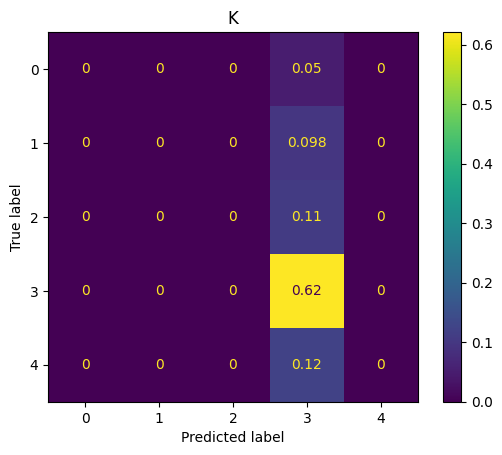

In [10]:
print("\n==== Task K: Create a Custom Convnet ====")
model_k = create_simple_model(params)
run_task(f"K", model_k, convert_dataset_to_float(ds_train), convert_dataset_to_float(ds_valid), convert_dataset_to_float(ds_test), params, collector)

In [14]:
for ds in [ds_train, ds_valid, ds_test]:
    print(model_k.model.evaluate(convert_dataset_to_float(ds)))

67/67 ━━━━━━━━━━━━━━━━━━━━ 28s 369ms/step - accuracy: 0.6139 - loss: 1.1945
[1.1968148946762085, 0.612370491027832]
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 283ms/step - accuracy: 0.6146 - loss: 1.1951
[1.1914072036743164, 0.6163551211357117]
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 340ms/step - accuracy: 0.4172 - loss: 1.5660
[1.2080401182174683, 0.6212616562843323]


In [18]:
del model_k

In [19]:
del ds_train_raw

In [14]:
params.opt = AdamW
print(params)

Params(image_size=255, batch_size=192, epochs=75, epsilon=0.0075, early_stopping=True, early_stopping_patience=7, adjust_learning_rate=False, opt=<class 'keras.src.optimizers.adamw.AdamW'>)



==== Task L: New Best of Breed ====
Running Task: L_init with params Params(image_size=255, batch_size=192, epochs=75, epsilon=0.0075, early_stopping=True, early_stopping_patience=7, adjust_learning_rate=False, opt=<class 'keras.src.optimizers.adamw.AdamW'>)
Using: <class 'keras.src.optimizers.adamw.AdamW'>
Using EarlyStopping
Epoch 1/75
134/134 ━━━━━━━━━━━━━━━━━━━━ 157s 842ms/step - accuracy: 0.5790 - loss: 1.1556 - val_accuracy: 0.7222 - val_loss: 0.7463
Epoch 2/75
134/134 ━━━━━━━━━━━━━━━━━━━━ 79s 569ms/step - accuracy: 0.7059 - loss: 0.7972 - val_accuracy: 0.7460 - val_loss: 0.6892
Epoch 3/75
134/134 ━━━━━━━━━━━━━━━━━━━━ 78s 564ms/step - accuracy: 0.7300 - loss: 0.7354 - val_accuracy: 0.7610 - val_loss: 0.6520
Epoch 4/75
134/134 ━━━━━━━━━━━━━━━━━━━━ 79s 571ms/step - accuracy: 0.7427 - loss: 0.6960 - val_accuracy: 0.7629 - val_loss: 0.6397
Epoch 5/75
134/134 ━━━━━━━━━━━━━━━━━━━━ 76s 550ms/step - accuracy: 0.7556 - loss: 0.6716 - val_accuracy: 0.7696 - val_loss: 0.6230
Epoch 6/75
134

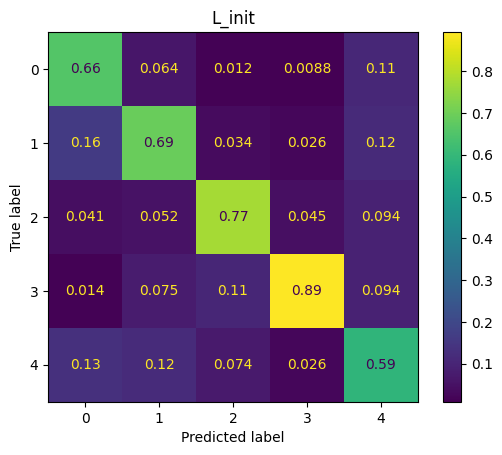

In [15]:
print("\n==== Task L: New Best of Breed ====")
model_l = create_model(tf.keras.applications.EfficientNetV2B0, params, 1)
run_task(f"L_init", model_l, ds_train_aug, ds_valid, ds_test, params, collector, class_weights)

In [9]:
params.opt = AdamW
params.epsilon = 0.0075
print(params)

Params(image_size=255, batch_size=192, epochs=75, epsilon=0.0075, early_stopping=True, early_stopping_patience=7, adjust_learning_rate=False, opt=<class 'keras.src.optimizers.adamw.AdamW'>)



==== Task L: New Best of Breed ====
24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Running Task: L_init with params Params(image_size=255, batch_size=192, epochs=75, epsilon=0.0075, early_stopping=True, early_stopping_patience=7, adjust_learning_rate=False, opt=<class 'keras.src.optimizers.adamw.AdamW'>)
Using: <class 'keras.src.optimizers.adamw.AdamW'>
Using EarlyStopping
Epoch 1/75
  1/134 ━━━━━━━━━━━━━━━━━━━━ 2:12:30 60s/step - accuracy: 0.1615 - loss: 1.7843

I0000 00:00:1712472116.932952     116 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


134/134 ━━━━━━━━━━━━━━━━━━━━ 189s 971ms/step - accuracy: 0.5809 - loss: 1.1317 - val_accuracy: 0.7208 - val_loss: 0.7420
Epoch 2/75
134/134 ━━━━━━━━━━━━━━━━━━━━ 83s 605ms/step - accuracy: 0.7060 - loss: 0.7921 - val_accuracy: 0.7502 - val_loss: 0.6750
Epoch 3/75
134/134 ━━━━━━━━━━━━━━━━━━━━ 84s 607ms/step - accuracy: 0.7330 - loss: 0.7345 - val_accuracy: 0.7631 - val_loss: 0.6531
Epoch 4/75
134/134 ━━━━━━━━━━━━━━━━━━━━ 83s 598ms/step - accuracy: 0.7434 - loss: 0.7013 - val_accuracy: 0.7643 - val_loss: 0.6300
Epoch 5/75
134/134 ━━━━━━━━━━━━━━━━━━━━ 81s 587ms/step - accuracy: 0.7525 - loss: 0.6783 - val_accuracy: 0.7727 - val_loss: 0.6235
Epoch 6/75
134/134 ━━━━━━━━━━━━━━━━━━━━ 79s 572ms/step - accuracy: 0.7648 - loss: 0.6473 - val_accuracy: 0.7736 - val_loss: 0.6095
Epoch 7/75
134/134 ━━━━━━━━━━━━━━━━━━━━ 82s 596ms/step - accuracy: 0.7647 - loss: 0.6443 - val_accuracy: 0.7794 - val_loss: 0.5973
Epoch 8/75
134/134 ━━━━━━━━━━━━━━━━━━━━ 82s 592ms/step - accuracy: 0.7759 - loss: 0.6262 - va

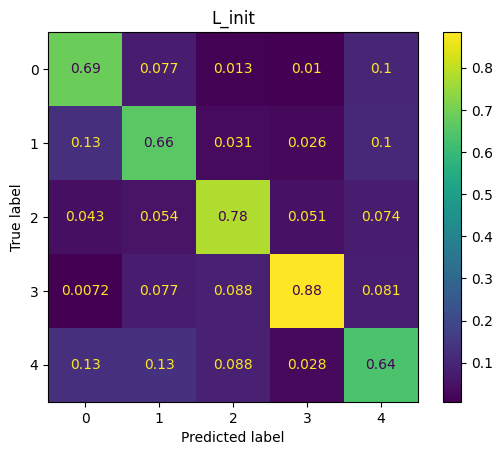

In [10]:
print("\n==== Task L: New Best of Breed ====")
ds_train_aug = augment_dataset(ds_train, 2)
model_l = create_model(tf.keras.applications.EfficientNetV2B0, params, 1)
run_task(f"L_init", model_l, ds_train_aug, ds_valid, ds_test, params, collector, class_weights)

In [11]:
model_l.base_model.trainable = True
ft_params = dataclasses.replace(params)
ft_params.epsilon = 1e-5
ft_params.early_stopping_patience = 3
print(ft_params)

Params(image_size=255, batch_size=192, epochs=75, epsilon=1e-05, early_stopping=True, early_stopping_patience=3, adjust_learning_rate=False, opt=<class 'keras.src.optimizers.adamw.AdamW'>)


Running Task: L_tuned with params Params(image_size=255, batch_size=192, epochs=75, epsilon=1e-05, early_stopping=True, early_stopping_patience=3, adjust_learning_rate=False, opt=<class 'keras.src.optimizers.adamw.AdamW'>)
Using: <class 'keras.src.optimizers.adamw.AdamW'>
Using EarlyStopping
Epoch 1/75


2024-04-07 07:33:03.038630: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[128,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[192,32,64,64]{3,2,1,0}, f32[192,128,64,64]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-04-07 07:33:03.158821: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.120317052s
Trying algorithm eng0{} for conv (f32[128,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[192,32,64,64]{3,2,1,0}, f32[192,128,64,64]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-04-07 07:33:04.562834: E external/

134/134 ━━━━━━━━━━━━━━━━━━━━ 328s 1s/step - accuracy: 0.7594 - loss: 0.6792 - val_accuracy: 0.8362 - val_loss: 0.4864
Epoch 2/75
134/134 ━━━━━━━━━━━━━━━━━━━━ 89s 648ms/step - accuracy: 0.8804 - loss: 0.3304 - val_accuracy: 0.7902 - val_loss: 0.6329
Epoch 3/75
134/134 ━━━━━━━━━━━━━━━━━━━━ 89s 644ms/step - accuracy: 0.9211 - loss: 0.2200 - val_accuracy: 0.8393 - val_loss: 0.6097
Epoch 4/75
134/134 ━━━━━━━━━━━━━━━━━━━━ 91s 657ms/step - accuracy: 0.9497 - loss: 0.1467 - val_accuracy: 0.8449 - val_loss: 0.6963
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 293ms/step - accuracy: 0.7767 - loss: 0.6331
23/23 ━━━━━━━━━━━━━━━━━━━━ 17s 498ms/step
Saving confusion matrix to artefacts


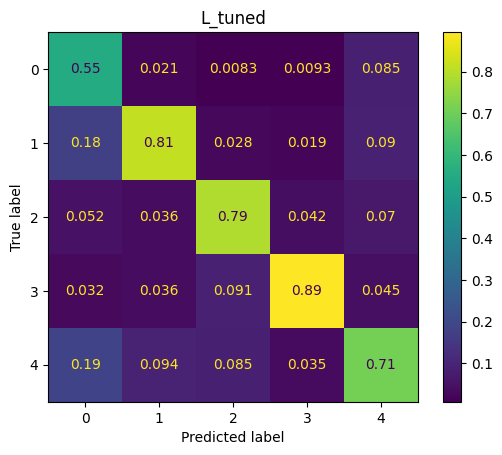

In [12]:
run_task(f"L_tuned", model_l, ds_train_aug, ds_valid, ds_test, ft_params, collector, class_weights)
#del model_d

In [15]:
model_l.model.evaluate(ds_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 289ms/step - accuracy: 0.7767 - loss: 0.6331


[0.4853076934814453, 0.8401868939399719]

In [16]:
model_l.model.evaluate(ds_valid)

23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 213ms/step - accuracy: 0.8346 - loss: 0.4961


[0.47592225670814514, 0.8362149596214294]

In [17]:
model_l.model.evaluate(ds_train_aug)

134/134 ━━━━━━━━━━━━━━━━━━━━ 75s 539ms/step - accuracy: 0.8769 - loss: 0.3377


[0.32617616653442383, 0.8815533518791199]

In [18]:
model_l.model.evaluate(ds_train)

67/67 ━━━━━━━━━━━━━━━━━━━━ 20s 268ms/step - accuracy: 0.8902 - loss: 0.3075


[0.2849550247192383, 0.8986523151397705]

In [15]:
print(params)

Params(image_size=255, batch_size=192, epochs=5, epsilon=0.005, early_stopping=True, early_stopping_patience=7, adjust_learning_rate=False, opt=<class 'keras.src.optimizers.adam.Adam'>)



==== Task Z: New Best of Breed ====
24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Running Task: Z with params Params(image_size=255, batch_size=192, epochs=5, epsilon=0.005, early_stopping=True, early_stopping_patience=7, adjust_learning_rate=False, opt=<class 'keras.src.optimizers.adam.Adam'>)
Using: <class 'keras.src.optimizers.adam.Adam'>
Using EarlyStopping
Epoch 1/5
67/67 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.5701 - loss: 1.1870 - val_accuracy: 0.7037 - val_loss: 0.7863
Epoch 2/5
67/67 ━━━━━━━━━━━━━━━━━━━━ 28s 385ms/step - accuracy: 0.6910 - loss: 0.8289 - val_accuracy: 0.7423 - val_loss: 0.7092
Epoch 3/5
67/67 ━━━━━━━━━━━━━━━━━━━━ 28s 387ms/step - accuracy: 0.7262 - loss: 0.7535 - val_accuracy: 0.7502 - val_loss: 0.6835
Epoch 4/5
67/67 ━━━━━━━━━━━━━━━━━━━━ 28s 381ms/step - accuracy: 0.7356 - loss: 0.7191 - val_accuracy: 0.7596 - val_loss: 0.6562
Epoch 5/5
67/67 ━━━━━━━━━━━━━━━━━━━━ 28s 383ms/step - accuracy: 0.7466 - loss: 0.6958 - val_accuracy: 0.7668 - val_loss:

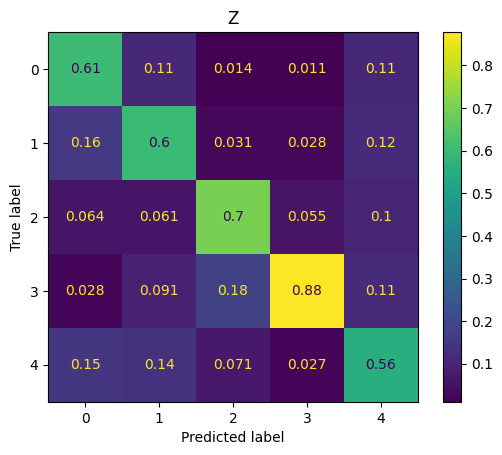

In [16]:
print("\n==== Task Z: New Best of Breed ====")
model_z = create_model(tf.keras.applications.EfficientNetV2B0, params, 1)
run_task(f"Z", model_z, ds_train, ds_valid, ds_test, params, collector, class_weights)

In [17]:
for ds in [ds_train, ds_valid, ds_test]:
    print(model_z.model.evaluate(ds))

67/67 ━━━━━━━━━━━━━━━━━━━━ 24s 329ms/step - accuracy: 0.7723 - loss: 0.6337
[0.6305554509162903, 0.7729220390319824]
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 210ms/step - accuracy: 0.7656 - loss: 0.6521
[0.646605908870697, 0.7668224573135376]
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 295ms/step - accuracy: 0.6601 - loss: 0.8888
[0.6388440728187561, 0.7850467562675476]


In [ ]:
m1 = create_model(tf.keras.applications.ConvNeXtTiny, params, 2, 1024)
m1.model.summary()